In [1]:
import importlib

import dataset, metrics, plotting, config
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

ModuleNotFoundError: No module named 'sklearn'

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "magical_sinus"
       or dataset_config.scenario == "hdpe"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [11]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.001, lr_disc=0.001, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=200),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [12]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [13]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(exp_config.dataset.n_instance,
                                                                         exp_config.dataset.scenario)

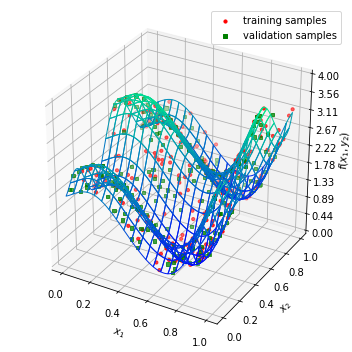

In [14]:
%matplotlib inline 
plotting.plot_dataset(X_train, X_valid, y_train, y_valid, exp_config, fig_dir)

## Finding sparse regions using Local Outlier Factor (LOF)

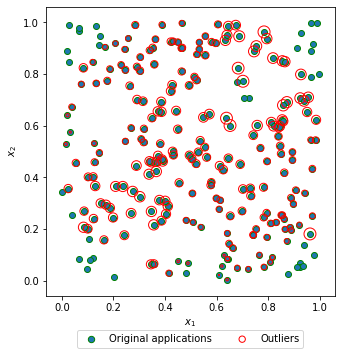

In [7]:
from sklearn.neighbors import LocalOutlierFactor


X = X_train
clf = LocalOutlierFactor(n_neighbors=240)
clf.fit(X)
X_scores = clf.negative_outlier_factor_
mean_scores = np.mean(X_scores)
mask = X_scores > mean_scores

X_outliers = X[mask]
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

if len(X_outliers):

    # plot the original data points where outliers are marked by cycles.
    # The more larger the circle, the more isolated the data points away from 
    # its neighbors.
    plotting.plot_sparse_regions(X, X_outliers, radius[mask], fig_dir)

## CVT sampling and discrepancy evaluating

In [8]:

from idaes.surrogate.pysmo import sampling as sp
from diversipy import unanchored_L2_discrepancy

assert len(X_outliers) !=0, "No sparse regions in the input space has been found."

min_n_sampling, max_n_sampling, interval = 60, 260, 20

minimum, maximum = np.amin(X_outliers, axis=0).tolist(), np.amax(X_outliers, axis=0).tolist()
bounds = [minimum, maximum]

X_discrepancy = unanchored_L2_discrepancy(X_outliers)
X_CVT_discrepancy_list, X_full_discrepancy_list, CVT_dict = [], [], {}
i = 0
for n_sampling in range(min_n_sampling, max_n_sampling, interval):
    space_init = sp.CVTSampling(bounds, sampling_type="creation", number_of_samples=n_sampling)
    X_CVT = space_init.sample_points()
    CVT_dict[f"num_sampling_{n_sampling}"] = X_CVT
    X_CVT_discrepancy = unanchored_L2_discrepancy(X_CVT)
    X_CVT_discrepancy_list.append(X_CVT_discrepancy)

    X_full = np.r_[X, X_CVT]
    X_full_discrepancy = unanchored_L2_discrepancy(X_full)
    X_full_discrepancy_list.append(X_full_discrepancy)
    print(f"Discrepancy values: {X_discrepancy:.4f} for original data; "
          f"{X_CVT_discrepancy:.4f} for {n_sampling} CVT samples; "
          f"{X_full_discrepancy:4f} for full data.")

best_n_sampling = np.arange(min_n_sampling, max_n_sampling, interval)[np.argmin(np.array(X_full_discrepancy_list))]
best_CVT = CVT_dict[f"num_sampling_{best_n_sampling}"]
print(f"The  optimal value for n_sampling in CVT sampling is {best_n_sampling}")

Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0155 for 60 CVT samples; 0.007397 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0107 for 80 CVT samples; 0.006415 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0088 for 100 CVT samples; 0.006746 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0092 for 120 CVT samples; 0.006094 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0092 for 140 CVT samples; 0.005970 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0085 for 160 CVT samples; 0.005512 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0059 for 180 CVT samples; 0.005401 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0088 for 200 CVT samples; 0.006300 for full data.
Sa

No handles with labels found to put in legend.


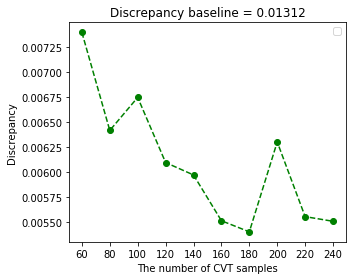

In [14]:
X_discrepancy = unanchored_L2_discrepancy(X_outliers)
plotting.plot_cvt_discrepancy(min_n_sampling, max_n_sampling, interval, X_full_discrepancy_list, fig_dir,
                              title=f"Discrepancy baseline = {X_discrepancy:2.5f}")

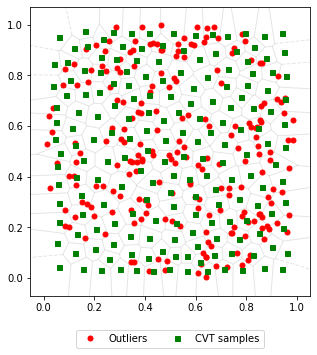

In [11]:
from scipy.spatial import Voronoi
from scipy.spatial import voronoi_plot_2d

sampling_key = f"num_sampling_{best_n_sampling}"
X_CVT = CVT_dict[sampling_key]

# plot CVT samples
plotting.plot_voronoi_cvt(X_outliers, X_CVT, Voronoi, voronoi_plot_2d, fig_dir)

# save CVT samples to .npy file
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_CVT_samples.npy", X_CVT)

## Gaussian Process 

In [7]:
import GPy

noise = 4.3
length = 16

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True)
ypred_gp_valid, cov_valid = gpr.predict(X_valid)

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


## Construct RegCGAN model

In [15]:
regcgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = regcgan.train(X_train, y_train,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=True)

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 2)            0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 20)           60          Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 20)           120         Generator_input_z[0][0]          
__________________________________________________________________________________________

Epoch: 53 / dLoss: 1.3478087186813354 / gLoss: 0.7546206712722778
Epoch: 54 / dLoss: 1.422428846359253 / gLoss: 0.7094336748123169
Epoch: 55 / dLoss: 1.4720098972320557 / gLoss: 0.6221610903739929
Epoch: 56 / dLoss: 1.5089976787567139 / gLoss: 0.5742303729057312
Epoch: 57 / dLoss: 1.5765280723571777 / gLoss: 0.5606256723403931
Epoch: 58 / dLoss: 1.535891056060791 / gLoss: 0.5488784313201904
Epoch: 59 / dLoss: 1.5385311841964722 / gLoss: 0.5360440611839294
Epoch: 60 / dLoss: 1.4959790706634521 / gLoss: 0.5403580069541931
Epoch: 61 / dLoss: 1.4783809185028076 / gLoss: 0.5510890483856201
Epoch: 62 / dLoss: 1.4374840259552002 / gLoss: 0.5604851841926575
Epoch: 63 / dLoss: 1.409904956817627 / gLoss: 0.578606367111206
Epoch: 64 / dLoss: 1.3813822269439697 / gLoss: 0.6079934239387512
Epoch: 65 / dLoss: 1.3615978956222534 / gLoss: 0.6237035989761353
Epoch: 66 / dLoss: 1.3661749362945557 / gLoss: 0.6431975364685059
Epoch: 67 / dLoss: 1.3465063571929932 / gLoss: 0.6620467305183411
Epoch: 68 / dL

Epoch: 177 / dLoss: 1.3881447315216064 / gLoss: 0.6180440783500671
Epoch: 178 / dLoss: 1.3858447074890137 / gLoss: 0.6394382119178772
Epoch: 179 / dLoss: 1.3834689855575562 / gLoss: 0.6874681711196899
Epoch: 180 / dLoss: 1.3542243242263794 / gLoss: 0.6925753951072693
Epoch: 181 / dLoss: 1.3759135007858276 / gLoss: 0.6870197057723999
Epoch: 182 / dLoss: 1.3824349641799927 / gLoss: 0.6847605109214783
Epoch: 183 / dLoss: 1.453869342803955 / gLoss: 0.6685382723808289
Epoch: 184 / dLoss: 1.4504854679107666 / gLoss: 0.6854560375213623
Epoch: 185 / dLoss: 1.4650441408157349 / gLoss: 0.6691321730613708
Epoch: 186 / dLoss: 1.4586827754974365 / gLoss: 0.6625921726226807
Epoch: 187 / dLoss: 1.438796877861023 / gLoss: 0.6691299676895142
Epoch: 188 / dLoss: 1.4541857242584229 / gLoss: 0.6779100298881531
Epoch: 189 / dLoss: 1.4567813873291016 / gLoss: 0.6857402324676514
Epoch: 190 / dLoss: 1.4327073097229004 / gLoss: 0.7053934335708618
Epoch: 191 / dLoss: 1.4158086776733398 / gLoss: 0.72249788045883

Epoch: 301 / dLoss: 1.586216688156128 / gLoss: 0.6561181545257568
Epoch: 302 / dLoss: 1.66328763961792 / gLoss: 0.637887716293335
Epoch: 303 / dLoss: 1.787879467010498 / gLoss: 0.5759636163711548
Epoch: 304 / dLoss: 1.7767785787582397 / gLoss: 0.5240135788917542
Epoch: 305 / dLoss: 1.7578496932983398 / gLoss: 0.5579360723495483
Epoch: 306 / dLoss: 1.6358669996261597 / gLoss: 0.5547058582305908
Epoch: 307 / dLoss: 1.5756489038467407 / gLoss: 0.579392671585083
Epoch: 308 / dLoss: 1.4675043821334839 / gLoss: 0.5972203612327576
Epoch: 309 / dLoss: 1.3539469242095947 / gLoss: 0.6321415901184082
Epoch: 310 / dLoss: 1.3136088848114014 / gLoss: 0.6847817897796631
Epoch: 311 / dLoss: 1.2744935750961304 / gLoss: 0.6764766573905945
Epoch: 312 / dLoss: 1.2389613389968872 / gLoss: 0.7055961489677429
Epoch: 313 / dLoss: 1.2502409219741821 / gLoss: 0.6973703503608704
Epoch: 314 / dLoss: 1.223508358001709 / gLoss: 0.726692795753479
Epoch: 315 / dLoss: 1.2464325428009033 / gLoss: 0.7426660060882568
Epo

Epoch: 424 / dLoss: 1.273068904876709 / gLoss: 1.1095525026321411
Epoch: 425 / dLoss: 1.2955827713012695 / gLoss: 1.0426291227340698
Epoch: 426 / dLoss: 1.3040696382522583 / gLoss: 0.957741916179657
Epoch: 427 / dLoss: 1.3249142169952393 / gLoss: 0.8712785840034485
Epoch: 428 / dLoss: 1.3789530992507935 / gLoss: 0.8063914775848389
Epoch: 429 / dLoss: 1.3954029083251953 / gLoss: 0.7671244144439697
Epoch: 430 / dLoss: 1.4028849601745605 / gLoss: 0.7268546223640442
Epoch: 431 / dLoss: 1.4419020414352417 / gLoss: 0.6977429986000061
Epoch: 432 / dLoss: 1.4398574829101562 / gLoss: 0.6672657132148743
Epoch: 433 / dLoss: 1.4987599849700928 / gLoss: 0.6449207067489624
Epoch: 434 / dLoss: 1.4865816831588745 / gLoss: 0.635638952255249
Epoch: 435 / dLoss: 1.4897047281265259 / gLoss: 0.6173675656318665
Epoch: 436 / dLoss: 1.464348316192627 / gLoss: 0.611700713634491
Epoch: 437 / dLoss: 1.4397047758102417 / gLoss: 0.6118029952049255
Epoch: 438 / dLoss: 1.4302873611450195 / gLoss: 0.6105333566665649


Epoch: 548 / dLoss: 1.3899898529052734 / gLoss: 0.7366161942481995
Epoch: 549 / dLoss: 1.3675180673599243 / gLoss: 0.7409961819648743
Epoch: 550 / dLoss: 1.3526318073272705 / gLoss: 0.7456471920013428
Epoch: 551 / dLoss: 1.3263713121414185 / gLoss: 0.7503084540367126
Epoch: 552 / dLoss: 1.3050956726074219 / gLoss: 0.7531576752662659
Epoch: 553 / dLoss: 1.2939236164093018 / gLoss: 0.7617408037185669
Epoch: 554 / dLoss: 1.2808680534362793 / gLoss: 0.7655811309814453
Epoch: 555 / dLoss: 1.2533209323883057 / gLoss: 0.7716901898384094
Epoch: 556 / dLoss: 1.2223265171051025 / gLoss: 0.7922179698944092
Epoch: 557 / dLoss: 1.208986759185791 / gLoss: 0.8077430129051208
Epoch: 558 / dLoss: 1.2065370082855225 / gLoss: 0.801167368888855
Epoch: 559 / dLoss: 1.2086892127990723 / gLoss: 0.8265645503997803
Epoch: 560 / dLoss: 1.1907176971435547 / gLoss: 0.8162422180175781
Epoch: 561 / dLoss: 1.2277417182922363 / gLoss: 0.8172340393066406
Epoch: 562 / dLoss: 1.230717658996582 / gLoss: 0.798980414867401

Epoch: 671 / dLoss: 1.4326696395874023 / gLoss: 0.7683144211769104
Epoch: 672 / dLoss: 1.430020809173584 / gLoss: 0.7624715566635132
Epoch: 673 / dLoss: 1.4442193508148193 / gLoss: 0.775987982749939
Epoch: 674 / dLoss: 1.4288243055343628 / gLoss: 0.78704434633255
Epoch: 675 / dLoss: 1.3824708461761475 / gLoss: 0.7858188152313232
Epoch: 676 / dLoss: 1.343498945236206 / gLoss: 0.7997757792472839
Epoch: 677 / dLoss: 1.3369622230529785 / gLoss: 0.8054643869400024
Epoch: 678 / dLoss: 1.2763476371765137 / gLoss: 0.8109047412872314
Epoch: 679 / dLoss: 1.2230135202407837 / gLoss: 0.7845156788825989
Epoch: 680 / dLoss: 1.156221866607666 / gLoss: 0.764324426651001
Epoch: 681 / dLoss: 1.1464648246765137 / gLoss: 0.7455530762672424
Epoch: 682 / dLoss: 1.1371409893035889 / gLoss: 0.7319830060005188
Epoch: 683 / dLoss: 1.1546131372451782 / gLoss: 0.7478580474853516
Epoch: 684 / dLoss: 1.0815342664718628 / gLoss: 0.7894466519355774
Epoch: 685 / dLoss: 1.1686221361160278 / gLoss: 0.8080168962478638
Ep

Epoch: 794 / dLoss: 1.3745713233947754 / gLoss: 0.7302951216697693
Epoch: 795 / dLoss: 1.379847526550293 / gLoss: 0.7334539294242859
Epoch: 796 / dLoss: 1.36750328540802 / gLoss: 0.7421632409095764
Epoch: 797 / dLoss: 1.3612644672393799 / gLoss: 0.7468883395195007
Epoch: 798 / dLoss: 1.3306317329406738 / gLoss: 0.748604953289032
Epoch: 799 / dLoss: 1.30342698097229 / gLoss: 0.7604435086250305
Epoch: 800 / dLoss: 1.298034429550171 / gLoss: 0.7645276784896851
Epoch: 801 / dLoss: 1.2244417667388916 / gLoss: 0.7718190550804138
Epoch: 802 / dLoss: 1.212607979774475 / gLoss: 0.7764880657196045
Epoch: 803 / dLoss: 1.2191373109817505 / gLoss: 0.7837867736816406
Epoch: 804 / dLoss: 1.2308520078659058 / gLoss: 0.7763935327529907
Epoch: 805 / dLoss: 1.1580777168273926 / gLoss: 0.7670811414718628
Epoch: 806 / dLoss: 1.1580623388290405 / gLoss: 0.7680642604827881
Epoch: 807 / dLoss: 1.1919186115264893 / gLoss: 0.7778069376945496
Epoch: 808 / dLoss: 1.1472244262695312 / gLoss: 0.7923158407211304
Epo

Epoch: 917 / dLoss: 1.5762585401535034 / gLoss: 0.6498412489891052
Epoch: 918 / dLoss: 1.5115811824798584 / gLoss: 0.6992993354797363
Epoch: 919 / dLoss: 1.467769980430603 / gLoss: 0.6938302516937256
Epoch: 920 / dLoss: 1.4311033487319946 / gLoss: 0.6811569333076477
Epoch: 921 / dLoss: 1.396700382232666 / gLoss: 0.6742827892303467
Epoch: 922 / dLoss: 1.3737916946411133 / gLoss: 0.6697008013725281
Epoch: 923 / dLoss: 1.3445199728012085 / gLoss: 0.6663268804550171
Epoch: 924 / dLoss: 1.3296818733215332 / gLoss: 0.6624387502670288
Epoch: 925 / dLoss: 1.3078193664550781 / gLoss: 0.6586979031562805
Epoch: 926 / dLoss: 1.3082332611083984 / gLoss: 0.6587222218513489
Epoch: 927 / dLoss: 1.2678215503692627 / gLoss: 0.655691921710968
Epoch: 928 / dLoss: 1.2525465488433838 / gLoss: 0.6582496166229248
Epoch: 929 / dLoss: 1.2833362817764282 / gLoss: 0.6629987955093384
Epoch: 930 / dLoss: 1.2855963706970215 / gLoss: 0.6566033959388733
Epoch: 931 / dLoss: 1.278730034828186 / gLoss: 0.6626467704772949

Epoch: 1040 / dLoss: 1.2113902568817139 / gLoss: 0.8866670727729797
Epoch: 1041 / dLoss: 1.1766713857650757 / gLoss: 0.8716927170753479
Epoch: 1042 / dLoss: 1.056311845779419 / gLoss: 0.8924025893211365
Epoch: 1043 / dLoss: 1.0849459171295166 / gLoss: 0.8392980694770813
Epoch: 1044 / dLoss: 1.088919758796692 / gLoss: 0.7717966437339783
Epoch: 1045 / dLoss: 1.151889443397522 / gLoss: 0.8097809553146362
Epoch: 1046 / dLoss: 1.2397228479385376 / gLoss: 0.7961036562919617
Epoch: 1047 / dLoss: 1.3054038286209106 / gLoss: 0.8444371223449707
Epoch: 1048 / dLoss: 1.3480925559997559 / gLoss: 0.8768243193626404
Epoch: 1049 / dLoss: 1.4512196779251099 / gLoss: 0.8796650767326355
Epoch: 1050 / dLoss: 1.5251281261444092 / gLoss: 0.9110385179519653
Epoch: 1051 / dLoss: 1.5070868730545044 / gLoss: 0.8647720217704773
Epoch: 1052 / dLoss: 1.6013638973236084 / gLoss: 0.80800461769104
Epoch: 1053 / dLoss: 1.6389551162719727 / gLoss: 0.7207725644111633
Epoch: 1054 / dLoss: 1.5769829750061035 / gLoss: 0.73

Epoch: 1162 / dLoss: 1.3712501525878906 / gLoss: 0.7054517865180969
Epoch: 1163 / dLoss: 1.3570854663848877 / gLoss: 0.6839587688446045
Epoch: 1164 / dLoss: 1.3344812393188477 / gLoss: 0.6714861392974854
Epoch: 1165 / dLoss: 1.3583238124847412 / gLoss: 0.6690640449523926
Epoch: 1166 / dLoss: 1.34733247756958 / gLoss: 0.6557821035385132
Epoch: 1167 / dLoss: 1.3423404693603516 / gLoss: 0.6607974171638489
Epoch: 1168 / dLoss: 1.3496174812316895 / gLoss: 0.6498862504959106
Epoch: 1169 / dLoss: 1.3254995346069336 / gLoss: 0.6665690541267395
Epoch: 1170 / dLoss: 1.3493245840072632 / gLoss: 0.6375910043716431
Epoch: 1171 / dLoss: 1.355876088142395 / gLoss: 0.6461715698242188
Epoch: 1172 / dLoss: 1.3745959997177124 / gLoss: 0.6571643352508545
Epoch: 1173 / dLoss: 1.3968992233276367 / gLoss: 0.6399810910224915
Epoch: 1174 / dLoss: 1.4002726078033447 / gLoss: 0.6477193236351013
Epoch: 1175 / dLoss: 1.4190254211425781 / gLoss: 0.6518622040748596
Epoch: 1176 / dLoss: 1.4143136739730835 / gLoss: 0.

Epoch: 1284 / dLoss: 1.5122313499450684 / gLoss: 0.6830921769142151
Epoch: 1285 / dLoss: 1.5196411609649658 / gLoss: 0.689268946647644
Epoch: 1286 / dLoss: 1.5289199352264404 / gLoss: 0.6913731098175049
Epoch: 1287 / dLoss: 1.5063307285308838 / gLoss: 0.720928966999054
Epoch: 1288 / dLoss: 1.505968451499939 / gLoss: 0.7349047660827637
Epoch: 1289 / dLoss: 1.4937336444854736 / gLoss: 0.7491195797920227
Epoch: 1290 / dLoss: 1.4821515083312988 / gLoss: 0.7813593149185181
Epoch: 1291 / dLoss: 1.4484328031539917 / gLoss: 0.7993772029876709
Epoch: 1292 / dLoss: 1.4282034635543823 / gLoss: 0.8110798597335815
Epoch: 1293 / dLoss: 1.4075510501861572 / gLoss: 0.8213511109352112
Epoch: 1294 / dLoss: 1.3936799764633179 / gLoss: 0.8237991333007812
Epoch: 1295 / dLoss: 1.3715262413024902 / gLoss: 0.8422532081604004
Epoch: 1296 / dLoss: 1.3607491254806519 / gLoss: 0.840675413608551
Epoch: 1297 / dLoss: 1.347640872001648 / gLoss: 0.8535299897193909
Epoch: 1298 / dLoss: 1.3424168825149536 / gLoss: 0.85

Epoch: 1406 / dLoss: 1.4084298610687256 / gLoss: 0.6944275498390198
Epoch: 1407 / dLoss: 1.4448589086532593 / gLoss: 0.6833301782608032
Epoch: 1408 / dLoss: 1.386902928352356 / gLoss: 0.7174132466316223
Epoch: 1409 / dLoss: 1.4206628799438477 / gLoss: 0.7052519917488098
Epoch: 1410 / dLoss: 1.4052742719650269 / gLoss: 0.7100871205329895
Epoch: 1411 / dLoss: 1.4263019561767578 / gLoss: 0.6984217762947083
Epoch: 1412 / dLoss: 1.42441725730896 / gLoss: 0.695259690284729
Epoch: 1413 / dLoss: 1.4073325395584106 / gLoss: 0.6949946880340576
Epoch: 1414 / dLoss: 1.3971058130264282 / gLoss: 0.6940059661865234
Epoch: 1415 / dLoss: 1.375591516494751 / gLoss: 0.6998884081840515
Epoch: 1416 / dLoss: 1.3982930183410645 / gLoss: 0.6822720170021057
Epoch: 1417 / dLoss: 1.3826895952224731 / gLoss: 0.6830000877380371
Epoch: 1418 / dLoss: 1.3821903467178345 / gLoss: 0.6823713779449463
Epoch: 1419 / dLoss: 1.372528076171875 / gLoss: 0.6885612607002258
Epoch: 1420 / dLoss: 1.3662089109420776 / gLoss: 0.689

Epoch: 1528 / dLoss: 1.3947622776031494 / gLoss: 0.6907225251197815
Epoch: 1529 / dLoss: 1.3778035640716553 / gLoss: 0.6873733401298523
Epoch: 1530 / dLoss: 1.3801462650299072 / gLoss: 0.7093302011489868
Epoch: 1531 / dLoss: 1.3814005851745605 / gLoss: 0.7005767226219177
Epoch: 1532 / dLoss: 1.3895626068115234 / gLoss: 0.7174374461174011
Epoch: 1533 / dLoss: 1.3766758441925049 / gLoss: 0.7206895351409912
Epoch: 1534 / dLoss: 1.3779513835906982 / gLoss: 0.7279685139656067
Epoch: 1535 / dLoss: 1.3799270391464233 / gLoss: 0.7317774891853333
Epoch: 1536 / dLoss: 1.3727425336837769 / gLoss: 0.7280297875404358
Epoch: 1537 / dLoss: 1.360994577407837 / gLoss: 0.7291987538337708
Epoch: 1538 / dLoss: 1.3667044639587402 / gLoss: 0.7387682199478149
Epoch: 1539 / dLoss: 1.3677924871444702 / gLoss: 0.7441256046295166
Epoch: 1540 / dLoss: 1.3507304191589355 / gLoss: 0.7366853356361389
Epoch: 1541 / dLoss: 1.3635354042053223 / gLoss: 0.7516130805015564
Epoch: 1542 / dLoss: 1.3477861881256104 / gLoss: 

Epoch: 1650 / dLoss: 1.353886604309082 / gLoss: 0.8598597049713135
Epoch: 1651 / dLoss: 1.2907731533050537 / gLoss: 0.9904451966285706
Epoch: 1652 / dLoss: 1.3062536716461182 / gLoss: 1.0222591161727905
Epoch: 1653 / dLoss: 1.3291668891906738 / gLoss: 0.9217562675476074
Epoch: 1654 / dLoss: 1.3472280502319336 / gLoss: 0.8702617883682251
Epoch: 1655 / dLoss: 1.4095187187194824 / gLoss: 0.7891436815261841
Epoch: 1656 / dLoss: 1.4325809478759766 / gLoss: 0.7320182919502258
Epoch: 1657 / dLoss: 1.4542467594146729 / gLoss: 0.6521661281585693
Epoch: 1658 / dLoss: 1.4216924905776978 / gLoss: 0.6326969265937805
Epoch: 1659 / dLoss: 1.4016990661621094 / gLoss: 0.6203122138977051
Epoch: 1660 / dLoss: 1.3914753198623657 / gLoss: 0.6403621435165405
Epoch: 1661 / dLoss: 1.3794465065002441 / gLoss: 0.6391732096672058
Epoch: 1662 / dLoss: 1.3689632415771484 / gLoss: 0.6555772423744202
Epoch: 1663 / dLoss: 1.3513643741607666 / gLoss: 0.6595581769943237
Epoch: 1664 / dLoss: 1.3471415042877197 / gLoss: 

Epoch: 1771 / dLoss: 1.3863836526870728 / gLoss: 0.731833279132843
Epoch: 1772 / dLoss: 1.3300940990447998 / gLoss: 0.7474363446235657
Epoch: 1773 / dLoss: 1.3202711343765259 / gLoss: 0.7353899478912354
Epoch: 1774 / dLoss: 1.3362606763839722 / gLoss: 0.7362552881240845
Epoch: 1775 / dLoss: 1.3121933937072754 / gLoss: 0.7468541860580444
Epoch: 1776 / dLoss: 1.3381521701812744 / gLoss: 0.7652972340583801
Epoch: 1777 / dLoss: 1.3070526123046875 / gLoss: 0.7684484124183655
Epoch: 1778 / dLoss: 1.3179603815078735 / gLoss: 0.7725477814674377
Epoch: 1779 / dLoss: 1.2966768741607666 / gLoss: 0.7760549783706665
Epoch: 1780 / dLoss: 1.3000324964523315 / gLoss: 0.7807304263114929
Epoch: 1781 / dLoss: 1.2898203134536743 / gLoss: 0.7806223034858704
Epoch: 1782 / dLoss: 1.266200304031372 / gLoss: 0.777815580368042
Epoch: 1783 / dLoss: 1.2696986198425293 / gLoss: 0.8071528673171997
Epoch: 1784 / dLoss: 1.2421374320983887 / gLoss: 0.7929588556289673
Epoch: 1785 / dLoss: 1.2614784240722656 / gLoss: 0.

Epoch: 1892 / dLoss: 1.3998900651931763 / gLoss: 0.7838781476020813
Epoch: 1893 / dLoss: 1.3170443773269653 / gLoss: 0.8716161847114563
Epoch: 1894 / dLoss: 1.2625402212142944 / gLoss: 1.0172226428985596
Epoch: 1895 / dLoss: 1.1715562343597412 / gLoss: 1.2410081624984741
Epoch: 1896 / dLoss: 1.1546887159347534 / gLoss: 1.2537704706192017
Epoch: 1897 / dLoss: 1.138964295387268 / gLoss: 1.227268099784851
Epoch: 1898 / dLoss: 1.2070904970169067 / gLoss: 1.0783599615097046
Epoch: 1899 / dLoss: 1.2841049432754517 / gLoss: 0.9431514143943787
Epoch: 1900 / dLoss: 1.3141227960586548 / gLoss: 0.8566145896911621
Epoch: 1901 / dLoss: 1.3896536827087402 / gLoss: 0.7754408121109009
Epoch: 1902 / dLoss: 1.4985642433166504 / gLoss: 0.6605105400085449
Epoch: 1903 / dLoss: 1.5413670539855957 / gLoss: 0.599395215511322
Epoch: 1904 / dLoss: 1.6202633380889893 / gLoss: 0.5673776865005493
Epoch: 1905 / dLoss: 1.5259816646575928 / gLoss: 0.6416446566581726
Epoch: 1906 / dLoss: 1.5394704341888428 / gLoss: 0.

Epoch: 2014 / dLoss: 1.400394082069397 / gLoss: 0.7079461812973022
Epoch: 2015 / dLoss: 1.3975322246551514 / gLoss: 0.7136192917823792
Epoch: 2016 / dLoss: 1.3907277584075928 / gLoss: 0.7248116135597229
Epoch: 2017 / dLoss: 1.3795874118804932 / gLoss: 0.7292540073394775
Epoch: 2018 / dLoss: 1.375849962234497 / gLoss: 0.7301328182220459
Epoch: 2019 / dLoss: 1.3716540336608887 / gLoss: 0.731931746006012
Epoch: 2020 / dLoss: 1.3608510494232178 / gLoss: 0.7449238300323486
Epoch: 2021 / dLoss: 1.3594481945037842 / gLoss: 0.7430278062820435
Epoch: 2022 / dLoss: 1.3471572399139404 / gLoss: 0.7506555914878845
Epoch: 2023 / dLoss: 1.3507994413375854 / gLoss: 0.7507795691490173
Epoch: 2024 / dLoss: 1.348982334136963 / gLoss: 0.7680090069770813
Epoch: 2025 / dLoss: 1.340174913406372 / gLoss: 0.7517915964126587
Epoch: 2026 / dLoss: 1.3473793268203735 / gLoss: 0.7456201910972595
Epoch: 2027 / dLoss: 1.3526067733764648 / gLoss: 0.7691410779953003
Epoch: 2028 / dLoss: 1.356671690940857 / gLoss: 0.745

Epoch: 2136 / dLoss: 1.3720401525497437 / gLoss: 0.7120572924613953
Epoch: 2137 / dLoss: 1.4084868431091309 / gLoss: 0.7013558745384216
Epoch: 2138 / dLoss: 1.4215080738067627 / gLoss: 0.6856986880302429
Epoch: 2139 / dLoss: 1.388339877128601 / gLoss: 0.7048225402832031
Epoch: 2140 / dLoss: 1.4412450790405273 / gLoss: 0.7017973065376282
Epoch: 2141 / dLoss: 1.4500000476837158 / gLoss: 0.736915647983551
Epoch: 2142 / dLoss: 1.451277494430542 / gLoss: 0.710340678691864
Epoch: 2143 / dLoss: 1.4681036472320557 / gLoss: 0.7289415001869202
Epoch: 2144 / dLoss: 1.471484899520874 / gLoss: 0.7317332625389099
Epoch: 2145 / dLoss: 1.467311978340149 / gLoss: 0.7425220012664795
Epoch: 2146 / dLoss: 1.471885323524475 / gLoss: 0.7392017245292664
Epoch: 2147 / dLoss: 1.444533109664917 / gLoss: 0.7501992583274841
Epoch: 2148 / dLoss: 1.4170544147491455 / gLoss: 0.7776763439178467
Epoch: 2149 / dLoss: 1.4010722637176514 / gLoss: 0.7943277955055237
Epoch: 2150 / dLoss: 1.3664755821228027 / gLoss: 0.81913

Epoch: 2258 / dLoss: 1.3200902938842773 / gLoss: 0.7456128001213074
Epoch: 2259 / dLoss: 1.3070321083068848 / gLoss: 0.7468804717063904
Epoch: 2260 / dLoss: 1.3094661235809326 / gLoss: 0.764000415802002
Epoch: 2261 / dLoss: 1.3071893453598022 / gLoss: 0.7542978525161743
Epoch: 2262 / dLoss: 1.2735141515731812 / gLoss: 0.7588735818862915
Epoch: 2263 / dLoss: 1.2990453243255615 / gLoss: 0.7627969980239868
Epoch: 2264 / dLoss: 1.3116095066070557 / gLoss: 0.7707388997077942
Epoch: 2265 / dLoss: 1.3005995750427246 / gLoss: 0.7570725083351135
Epoch: 2266 / dLoss: 1.3385014533996582 / gLoss: 0.7817050218582153
Epoch: 2267 / dLoss: 1.302154541015625 / gLoss: 0.7840545773506165
Epoch: 2268 / dLoss: 1.357224464416504 / gLoss: 0.7607322931289673
Epoch: 2269 / dLoss: 1.368321418762207 / gLoss: 0.7644961476325989
Epoch: 2270 / dLoss: 1.3968584537506104 / gLoss: 0.7549220323562622
Epoch: 2271 / dLoss: 1.3920807838439941 / gLoss: 0.7472180724143982
Epoch: 2272 / dLoss: 1.4000273942947388 / gLoss: 0.7

Epoch: 2380 / dLoss: 1.397857904434204 / gLoss: 0.6687580347061157
Epoch: 2381 / dLoss: 1.4015508890151978 / gLoss: 0.6647380590438843
Epoch: 2382 / dLoss: 1.4041738510131836 / gLoss: 0.6638119220733643
Epoch: 2383 / dLoss: 1.4139235019683838 / gLoss: 0.6718401908874512
Epoch: 2384 / dLoss: 1.4146251678466797 / gLoss: 0.6692322492599487
Epoch: 2385 / dLoss: 1.3930420875549316 / gLoss: 0.6927688121795654
Epoch: 2386 / dLoss: 1.4108624458312988 / gLoss: 0.681107759475708
Epoch: 2387 / dLoss: 1.3999556303024292 / gLoss: 0.6791574954986572
Epoch: 2388 / dLoss: 1.3919211626052856 / gLoss: 0.6754226684570312
Epoch: 2389 / dLoss: 1.4015510082244873 / gLoss: 0.6659283638000488
Epoch: 2390 / dLoss: 1.3962078094482422 / gLoss: 0.6695255041122437
Epoch: 2391 / dLoss: 1.3874175548553467 / gLoss: 0.6675636768341064
Epoch: 2392 / dLoss: 1.398902416229248 / gLoss: 0.6676205992698669
Epoch: 2393 / dLoss: 1.3903722763061523 / gLoss: 0.6704059839248657
Epoch: 2394 / dLoss: 1.3821340799331665 / gLoss: 0.

Epoch: 2502 / dLoss: 1.3172155618667603 / gLoss: 0.7615304589271545
Epoch: 2503 / dLoss: 1.3186843395233154 / gLoss: 0.7699706554412842
Epoch: 2504 / dLoss: 1.2771995067596436 / gLoss: 0.7689765691757202
Epoch: 2505 / dLoss: 1.2999576330184937 / gLoss: 0.7754278779029846
Epoch: 2506 / dLoss: 1.284325361251831 / gLoss: 0.7891676425933838
Epoch: 2507 / dLoss: 1.30354905128479 / gLoss: 0.7839664220809937
Epoch: 2508 / dLoss: 1.3309125900268555 / gLoss: 0.7834398746490479
Epoch: 2509 / dLoss: 1.2853477001190186 / gLoss: 0.7865742444992065
Epoch: 2510 / dLoss: 1.317122220993042 / gLoss: 0.779487669467926
Epoch: 2511 / dLoss: 1.3771847486495972 / gLoss: 0.7346148490905762
Epoch: 2512 / dLoss: 1.3273261785507202 / gLoss: 0.7321286201477051
Epoch: 2513 / dLoss: 1.405778408050537 / gLoss: 0.8224695324897766
Epoch: 2514 / dLoss: 1.4652652740478516 / gLoss: 0.6766567230224609
Epoch: 2515 / dLoss: 1.4794104099273682 / gLoss: 0.6789920926094055
Epoch: 2516 / dLoss: 1.4045801162719727 / gLoss: 0.670

Epoch: 2624 / dLoss: 1.3258328437805176 / gLoss: 0.7274715304374695
Epoch: 2625 / dLoss: 1.326801061630249 / gLoss: 0.725067138671875
Epoch: 2626 / dLoss: 1.3221676349639893 / gLoss: 0.7272363901138306
Epoch: 2627 / dLoss: 1.3225021362304688 / gLoss: 0.7399117946624756
Epoch: 2628 / dLoss: 1.3448877334594727 / gLoss: 0.7523366808891296
Epoch: 2629 / dLoss: 1.3442972898483276 / gLoss: 0.7627326846122742
Epoch: 2630 / dLoss: 1.3331255912780762 / gLoss: 0.7739124298095703
Epoch: 2631 / dLoss: 1.3301424980163574 / gLoss: 0.7645960450172424
Epoch: 2632 / dLoss: 1.3860242366790771 / gLoss: 0.7698891162872314
Epoch: 2633 / dLoss: 1.388504981994629 / gLoss: 0.7767941951751709
Epoch: 2634 / dLoss: 1.376236915588379 / gLoss: 0.7905558943748474
Epoch: 2635 / dLoss: 1.3716628551483154 / gLoss: 0.7909128069877625
Epoch: 2636 / dLoss: 1.3469347953796387 / gLoss: 0.8159882426261902
Epoch: 2637 / dLoss: 1.365318775177002 / gLoss: 0.853312075138092
Epoch: 2638 / dLoss: 1.3386635780334473 / gLoss: 0.853

Epoch: 2746 / dLoss: 1.2526429891586304 / gLoss: 0.7826871275901794
Epoch: 2747 / dLoss: 1.281982660293579 / gLoss: 0.7011865973472595
Epoch: 2748 / dLoss: 1.2930395603179932 / gLoss: 0.7139456868171692
Epoch: 2749 / dLoss: 1.324995994567871 / gLoss: 0.6952882409095764
Epoch: 2750 / dLoss: 1.444913387298584 / gLoss: 0.711143434047699
Epoch: 2751 / dLoss: 1.4079868793487549 / gLoss: 0.7083749175071716
Epoch: 2752 / dLoss: 1.4826741218566895 / gLoss: 0.7164027690887451
Epoch: 2753 / dLoss: 1.4606213569641113 / gLoss: 0.6959165930747986
Epoch: 2754 / dLoss: 1.526877522468567 / gLoss: 0.6833957433700562
Epoch: 2755 / dLoss: 1.577383041381836 / gLoss: 0.7168097496032715
Epoch: 2756 / dLoss: 1.5820512771606445 / gLoss: 0.5924528241157532
Epoch: 2757 / dLoss: 1.5931191444396973 / gLoss: 0.6149701476097107
Epoch: 2758 / dLoss: 1.5779234170913696 / gLoss: 0.6329360008239746
Epoch: 2759 / dLoss: 1.4772156476974487 / gLoss: 0.6866825222969055
Epoch: 2760 / dLoss: 1.449244737625122 / gLoss: 0.6732

Epoch: 2868 / dLoss: 1.408869981765747 / gLoss: 0.7363787889480591
Epoch: 2869 / dLoss: 1.4021339416503906 / gLoss: 0.7378814220428467
Epoch: 2870 / dLoss: 1.3968493938446045 / gLoss: 0.736675500869751
Epoch: 2871 / dLoss: 1.3982083797454834 / gLoss: 0.739347517490387
Epoch: 2872 / dLoss: 1.3754562139511108 / gLoss: 0.7451398968696594
Epoch: 2873 / dLoss: 1.4021832942962646 / gLoss: 0.7506201267242432
Epoch: 2874 / dLoss: 1.3851573467254639 / gLoss: 0.7518926858901978
Epoch: 2875 / dLoss: 1.377809762954712 / gLoss: 0.7549155950546265
Epoch: 2876 / dLoss: 1.3745120763778687 / gLoss: 0.7584083676338196
Epoch: 2877 / dLoss: 1.3648391962051392 / gLoss: 0.75917649269104
Epoch: 2878 / dLoss: 1.342643141746521 / gLoss: 0.7636675238609314
Epoch: 2879 / dLoss: 1.362534999847412 / gLoss: 0.7646685838699341
Epoch: 2880 / dLoss: 1.3466535806655884 / gLoss: 0.7736693024635315
Epoch: 2881 / dLoss: 1.3505897521972656 / gLoss: 0.7744393944740295
Epoch: 2882 / dLoss: 1.3512852191925049 / gLoss: 0.78064

Epoch: 2990 / dLoss: 1.2953534126281738 / gLoss: 0.8602283596992493
Epoch: 2991 / dLoss: 1.2963001728057861 / gLoss: 0.8674055337905884
Epoch: 2992 / dLoss: 1.324512243270874 / gLoss: 0.869993269443512
Epoch: 2993 / dLoss: 1.2537667751312256 / gLoss: 0.8606823682785034
Epoch: 2994 / dLoss: 1.294847846031189 / gLoss: 0.8536441326141357
Epoch: 2995 / dLoss: 1.3048627376556396 / gLoss: 0.8509362936019897
Epoch: 2996 / dLoss: 1.294933557510376 / gLoss: 0.8307329416275024
Epoch: 2997 / dLoss: 1.3015799522399902 / gLoss: 0.8134261965751648
Epoch: 2998 / dLoss: 1.3462001085281372 / gLoss: 0.8087063431739807
Epoch: 2999 / dLoss: 1.3199288845062256 / gLoss: 0.7868055701255798
Epoch: 3000 / dLoss: 1.3851563930511475 / gLoss: 0.7810575366020203
Epoch: 3001 / dLoss: 1.3236539363861084 / gLoss: 0.7554537057876587
Epoch: 3002 / dLoss: 1.3738439083099365 / gLoss: 0.7516326904296875
Epoch: 3003 / dLoss: 1.382948398590088 / gLoss: 0.7409937977790833
Epoch: 3004 / dLoss: 1.3790650367736816 / gLoss: 0.70

Epoch: 3112 / dLoss: 1.3542301654815674 / gLoss: 0.6881845593452454
Epoch: 3113 / dLoss: 1.3269946575164795 / gLoss: 0.7313845157623291
Epoch: 3114 / dLoss: 1.3478717803955078 / gLoss: 0.7401279211044312
Epoch: 3115 / dLoss: 1.3187971115112305 / gLoss: 0.730661928653717
Epoch: 3116 / dLoss: 1.3160779476165771 / gLoss: 0.7341497540473938
Epoch: 3117 / dLoss: 1.3327897787094116 / gLoss: 0.7395613789558411
Epoch: 3118 / dLoss: 1.3696765899658203 / gLoss: 0.7251736521720886
Epoch: 3119 / dLoss: 1.3934144973754883 / gLoss: 0.7067546248435974
Epoch: 3120 / dLoss: 1.3708133697509766 / gLoss: 0.668561577796936
Epoch: 3121 / dLoss: 1.466367244720459 / gLoss: 0.6610965728759766
Epoch: 3122 / dLoss: 1.4507766962051392 / gLoss: 0.6757071018218994
Epoch: 3123 / dLoss: 1.4782283306121826 / gLoss: 0.6585361957550049
Epoch: 3124 / dLoss: 1.45261812210083 / gLoss: 0.648154616355896
Epoch: 3125 / dLoss: 1.4704294204711914 / gLoss: 0.6189997792243958
Epoch: 3126 / dLoss: 1.414735198020935 / gLoss: 0.6187

Epoch: 3234 / dLoss: 1.2886226177215576 / gLoss: 0.9358518123626709
Epoch: 3235 / dLoss: 1.2206029891967773 / gLoss: 1.0003186464309692
Epoch: 3236 / dLoss: 1.2411634922027588 / gLoss: 0.9456035494804382
Epoch: 3237 / dLoss: 1.24580717086792 / gLoss: 0.9633409976959229
Epoch: 3238 / dLoss: 1.2131402492523193 / gLoss: 0.9243211150169373
Epoch: 3239 / dLoss: 1.3017408847808838 / gLoss: 0.8466637134552002
Epoch: 3240 / dLoss: 1.396446704864502 / gLoss: 0.8223647475242615
Epoch: 3241 / dLoss: 1.456416130065918 / gLoss: 0.8127697706222534
Epoch: 3242 / dLoss: 1.6417369842529297 / gLoss: 0.7180556654930115
Epoch: 3243 / dLoss: 1.6278584003448486 / gLoss: 0.6815617084503174
Epoch: 3244 / dLoss: 1.52188241481781 / gLoss: 0.675201416015625
Epoch: 3245 / dLoss: 1.5587384700775146 / gLoss: 0.6213160753250122
Epoch: 3246 / dLoss: 1.4729077816009521 / gLoss: 0.6416888236999512
Epoch: 3247 / dLoss: 1.4317830801010132 / gLoss: 0.6669113039970398
Epoch: 3248 / dLoss: 1.4201682806015015 / gLoss: 0.6860

Epoch: 3355 / dLoss: 1.0987839698791504 / gLoss: 0.9138774275779724
Epoch: 3356 / dLoss: 1.1083186864852905 / gLoss: 0.8891937136650085
Epoch: 3357 / dLoss: 1.1159076690673828 / gLoss: 0.8991802334785461
Epoch: 3358 / dLoss: 1.1000336408615112 / gLoss: 0.9089682102203369
Epoch: 3359 / dLoss: 1.2152901887893677 / gLoss: 0.8854250907897949
Epoch: 3360 / dLoss: 1.1794450283050537 / gLoss: 0.8689729571342468
Epoch: 3361 / dLoss: 1.203796625137329 / gLoss: 0.8061975240707397
Epoch: 3362 / dLoss: 1.412168025970459 / gLoss: 0.8177139163017273
Epoch: 3363 / dLoss: 1.3163154125213623 / gLoss: 0.821401059627533
Epoch: 3364 / dLoss: 1.4164211750030518 / gLoss: 0.7694397568702698
Epoch: 3365 / dLoss: 1.5410807132720947 / gLoss: 0.7211892604827881
Epoch: 3366 / dLoss: 1.5362398624420166 / gLoss: 0.7634695172309875
Epoch: 3367 / dLoss: 1.4657073020935059 / gLoss: 0.8338862061500549
Epoch: 3368 / dLoss: 1.4530370235443115 / gLoss: 0.7747954726219177
Epoch: 3369 / dLoss: 1.3503820896148682 / gLoss: 0.

Epoch: 3477 / dLoss: 1.3479903936386108 / gLoss: 0.7515657544136047
Epoch: 3478 / dLoss: 1.388946533203125 / gLoss: 0.7514972686767578
Epoch: 3479 / dLoss: 1.3372623920440674 / gLoss: 0.75227952003479
Epoch: 3480 / dLoss: 1.3848373889923096 / gLoss: 0.7481446862220764
Epoch: 3481 / dLoss: 1.3381080627441406 / gLoss: 0.766823947429657
Epoch: 3482 / dLoss: 1.365454912185669 / gLoss: 0.7710396647453308
Epoch: 3483 / dLoss: 1.374158501625061 / gLoss: 0.779533326625824
Epoch: 3484 / dLoss: 1.3833844661712646 / gLoss: 0.7758405804634094
Epoch: 3485 / dLoss: 1.3528780937194824 / gLoss: 0.7930015325546265
Epoch: 3486 / dLoss: 1.3476781845092773 / gLoss: 0.7849847674369812
Epoch: 3487 / dLoss: 1.3888969421386719 / gLoss: 0.8039398789405823
Epoch: 3488 / dLoss: 1.3829560279846191 / gLoss: 0.8291993737220764
Epoch: 3489 / dLoss: 1.350306510925293 / gLoss: 0.8087174892425537
Epoch: 3490 / dLoss: 1.3250956535339355 / gLoss: 0.8409498333930969
Epoch: 3491 / dLoss: 1.3246272802352905 / gLoss: 0.83542

Epoch: 3599 / dLoss: 1.424826979637146 / gLoss: 0.7862328886985779
Epoch: 3600 / dLoss: 1.404833436012268 / gLoss: 0.8505510687828064
Epoch: 3601 / dLoss: 1.4543254375457764 / gLoss: 0.8434308767318726
Epoch: 3602 / dLoss: 1.3635118007659912 / gLoss: 0.8498313426971436
Epoch: 3603 / dLoss: 1.430988073348999 / gLoss: 0.8693544268608093
Epoch: 3604 / dLoss: 1.41798996925354 / gLoss: 0.8969126343727112
Epoch: 3605 / dLoss: 1.3970963954925537 / gLoss: 0.9122798442840576
Epoch: 3606 / dLoss: 1.3740544319152832 / gLoss: 0.9396571516990662
Epoch: 3607 / dLoss: 1.3690576553344727 / gLoss: 0.9348289966583252
Epoch: 3608 / dLoss: 1.3326044082641602 / gLoss: 0.9672238826751709
Epoch: 3609 / dLoss: 1.3959976434707642 / gLoss: 0.9643434286117554
Epoch: 3610 / dLoss: 1.3516937494277954 / gLoss: 1.0161030292510986
Epoch: 3611 / dLoss: 1.290969729423523 / gLoss: 1.0087080001831055
Epoch: 3612 / dLoss: 1.262065052986145 / gLoss: 1.025935411453247
Epoch: 3613 / dLoss: 1.2768821716308594 / gLoss: 1.13910

Epoch: 3721 / dLoss: 1.356935739517212 / gLoss: 0.7245194911956787
Epoch: 3722 / dLoss: 1.3743586540222168 / gLoss: 0.6819095015525818
Epoch: 3723 / dLoss: 1.3901633024215698 / gLoss: 0.6755902171134949
Epoch: 3724 / dLoss: 1.356847882270813 / gLoss: 0.6768569350242615
Epoch: 3725 / dLoss: 1.3771764039993286 / gLoss: 0.6717703938484192
Epoch: 3726 / dLoss: 1.3455438613891602 / gLoss: 0.6909729838371277
Epoch: 3727 / dLoss: 1.3458409309387207 / gLoss: 0.7091676592826843
Epoch: 3728 / dLoss: 1.3511028289794922 / gLoss: 0.661663293838501
Epoch: 3729 / dLoss: 1.3519833087921143 / gLoss: 0.6946447491645813
Epoch: 3730 / dLoss: 1.348857045173645 / gLoss: 0.6621105074882507
Epoch: 3731 / dLoss: 1.3418991565704346 / gLoss: 0.6935232281684875
Epoch: 3732 / dLoss: 1.3472747802734375 / gLoss: 0.7085112929344177
Epoch: 3733 / dLoss: 1.33268141746521 / gLoss: 0.712444543838501
Epoch: 3734 / dLoss: 1.3498749732971191 / gLoss: 0.7081857323646545
Epoch: 3735 / dLoss: 1.3643395900726318 / gLoss: 0.7499

Epoch: 3843 / dLoss: 1.1537792682647705 / gLoss: 0.8641104698181152
Epoch: 3844 / dLoss: 1.2010481357574463 / gLoss: 0.8075481653213501
Epoch: 3845 / dLoss: 1.2149298191070557 / gLoss: 0.8360427021980286
Epoch: 3846 / dLoss: 1.2879390716552734 / gLoss: 0.7876561880111694
Epoch: 3847 / dLoss: 1.3628580570220947 / gLoss: 0.8756042718887329
Epoch: 3848 / dLoss: 1.4620851278305054 / gLoss: 0.8307385444641113
Epoch: 3849 / dLoss: 1.7088797092437744 / gLoss: 0.7191851139068604
Epoch: 3850 / dLoss: 1.6553566455841064 / gLoss: 0.8099215626716614
Epoch: 3851 / dLoss: 1.7803268432617188 / gLoss: 0.7042766809463501
Epoch: 3852 / dLoss: 1.5642330646514893 / gLoss: 0.8678682446479797
Epoch: 3853 / dLoss: 1.4584704637527466 / gLoss: 1.2727363109588623
Epoch: 3854 / dLoss: 1.3380964994430542 / gLoss: 1.4391818046569824
Epoch: 3855 / dLoss: 1.3356566429138184 / gLoss: 1.338905930519104
Epoch: 3856 / dLoss: 1.3573098182678223 / gLoss: 1.0749391317367554
Epoch: 3857 / dLoss: 1.4424378871917725 / gLoss: 

Epoch: 3965 / dLoss: 1.209649920463562 / gLoss: 0.9711489677429199
Epoch: 3966 / dLoss: 1.1854476928710938 / gLoss: 0.9649731516838074
Epoch: 3967 / dLoss: 1.1742231845855713 / gLoss: 0.9895245432853699
Epoch: 3968 / dLoss: 1.1441280841827393 / gLoss: 0.9900836944580078
Epoch: 3969 / dLoss: 1.136645793914795 / gLoss: 0.9365461468696594
Epoch: 3970 / dLoss: 1.1752632856369019 / gLoss: 0.9214948415756226
Epoch: 3971 / dLoss: 1.1405267715454102 / gLoss: 0.866209864616394
Epoch: 3972 / dLoss: 1.2214751243591309 / gLoss: 0.8782487511634827
Epoch: 3973 / dLoss: 1.161914587020874 / gLoss: 0.8209779262542725
Epoch: 3974 / dLoss: 1.2448029518127441 / gLoss: 0.8270013928413391
Epoch: 3975 / dLoss: 1.1899659633636475 / gLoss: 0.832919716835022
Epoch: 3976 / dLoss: 1.2783880233764648 / gLoss: 0.7922987937927246
Epoch: 3977 / dLoss: 1.3004341125488281 / gLoss: 0.7856766581535339
Epoch: 3978 / dLoss: 1.2699429988861084 / gLoss: 0.7581932544708252
Epoch: 3979 / dLoss: 1.4839105606079102 / gLoss: 0.73

Epoch: 4087 / dLoss: 1.2535289525985718 / gLoss: 0.7317311763763428
Epoch: 4088 / dLoss: 1.2521181106567383 / gLoss: 0.751901388168335
Epoch: 4089 / dLoss: 1.253011703491211 / gLoss: 0.7905515432357788
Epoch: 4090 / dLoss: 1.2943065166473389 / gLoss: 0.8095673322677612
Epoch: 4091 / dLoss: 1.2868046760559082 / gLoss: 0.8044175505638123
Epoch: 4092 / dLoss: 1.2334132194519043 / gLoss: 0.8296192288398743
Epoch: 4093 / dLoss: 1.33453369140625 / gLoss: 0.8845885396003723
Epoch: 4094 / dLoss: 1.2299494743347168 / gLoss: 0.8620832562446594
Epoch: 4095 / dLoss: 1.2668859958648682 / gLoss: 0.9028218984603882
Epoch: 4096 / dLoss: 1.240027666091919 / gLoss: 0.8907975554466248
Epoch: 4097 / dLoss: 1.2460331916809082 / gLoss: 0.9178000092506409
Epoch: 4098 / dLoss: 1.3061256408691406 / gLoss: 0.9351449608802795
Epoch: 4099 / dLoss: 1.2829930782318115 / gLoss: 0.8998255133628845
Epoch: 4100 / dLoss: 1.2625651359558105 / gLoss: 0.9135389924049377
Epoch: 4101 / dLoss: 1.3549489974975586 / gLoss: 0.87

Epoch: 4208 / dLoss: 1.2183579206466675 / gLoss: 1.3598191738128662
Epoch: 4209 / dLoss: 1.118143081665039 / gLoss: 1.4130052328109741
Epoch: 4210 / dLoss: 1.055988073348999 / gLoss: 1.410264492034912
Epoch: 4211 / dLoss: 1.0917134284973145 / gLoss: 1.3893734216690063
Epoch: 4212 / dLoss: 1.0279163122177124 / gLoss: 1.303726315498352
Epoch: 4213 / dLoss: 1.054388165473938 / gLoss: 1.1751176118850708
Epoch: 4214 / dLoss: 1.1195533275604248 / gLoss: 0.9963294267654419
Epoch: 4215 / dLoss: 1.2807438373565674 / gLoss: 0.841133177280426
Epoch: 4216 / dLoss: 1.4044463634490967 / gLoss: 0.7340439558029175
Epoch: 4217 / dLoss: 1.5568089485168457 / gLoss: 0.6118594408035278
Epoch: 4218 / dLoss: 1.620886206626892 / gLoss: 0.582091212272644
Epoch: 4219 / dLoss: 1.6763222217559814 / gLoss: 0.6040560007095337
Epoch: 4220 / dLoss: 1.4469993114471436 / gLoss: 0.8518128395080566
Epoch: 4221 / dLoss: 1.3386051654815674 / gLoss: 0.9949789643287659
Epoch: 4222 / dLoss: 1.3559740781784058 / gLoss: 0.78649

Epoch: 4330 / dLoss: 1.2964389324188232 / gLoss: 0.7808617353439331
Epoch: 4331 / dLoss: 1.3507359027862549 / gLoss: 0.7647454738616943
Epoch: 4332 / dLoss: 1.334373950958252 / gLoss: 0.8100559115409851
Epoch: 4333 / dLoss: 1.2898427248001099 / gLoss: 0.7519602179527283
Epoch: 4334 / dLoss: 1.3551714420318604 / gLoss: 0.8066580891609192
Epoch: 4335 / dLoss: 1.3500046730041504 / gLoss: 0.8026748895645142
Epoch: 4336 / dLoss: 1.3423229455947876 / gLoss: 0.7919088006019592
Epoch: 4337 / dLoss: 1.3868345022201538 / gLoss: 0.7878039479255676
Epoch: 4338 / dLoss: 1.3105238676071167 / gLoss: 0.7803690433502197
Epoch: 4339 / dLoss: 1.302474021911621 / gLoss: 0.7326421141624451
Epoch: 4340 / dLoss: 1.3606635332107544 / gLoss: 0.785142719745636
Epoch: 4341 / dLoss: 1.3113811016082764 / gLoss: 0.7538313269615173
Epoch: 4342 / dLoss: 1.3226854801177979 / gLoss: 0.7828032970428467
Epoch: 4343 / dLoss: 1.330397367477417 / gLoss: 0.7813644409179688
Epoch: 4344 / dLoss: 1.2811472415924072 / gLoss: 0.7

Epoch: 4452 / dLoss: 1.3303077220916748 / gLoss: 0.7220526933670044
Epoch: 4453 / dLoss: 1.2663991451263428 / gLoss: 0.7502458691596985
Epoch: 4454 / dLoss: 1.3075642585754395 / gLoss: 0.7645729184150696
Epoch: 4455 / dLoss: 1.2688560485839844 / gLoss: 0.7640817761421204
Epoch: 4456 / dLoss: 1.268768072128296 / gLoss: 0.7347354888916016
Epoch: 4457 / dLoss: 1.3001728057861328 / gLoss: 0.7695519328117371
Epoch: 4458 / dLoss: 1.205966830253601 / gLoss: 0.8086948990821838
Epoch: 4459 / dLoss: 1.2757245302200317 / gLoss: 0.7379407286643982
Epoch: 4460 / dLoss: 1.363095760345459 / gLoss: 0.7591612339019775
Epoch: 4461 / dLoss: 1.3308188915252686 / gLoss: 0.8060138821601868
Epoch: 4462 / dLoss: 1.3220810890197754 / gLoss: 0.7409810423851013
Epoch: 4463 / dLoss: 1.3699939250946045 / gLoss: 0.783083975315094
Epoch: 4464 / dLoss: 1.387644648551941 / gLoss: 0.7905820608139038
Epoch: 4465 / dLoss: 1.339752197265625 / gLoss: 0.8610101342201233
Epoch: 4466 / dLoss: 1.3752036094665527 / gLoss: 0.857

Epoch: 4574 / dLoss: 1.3263964653015137 / gLoss: 0.8661991953849792
Epoch: 4575 / dLoss: 1.2748042345046997 / gLoss: 0.8413102626800537
Epoch: 4576 / dLoss: 1.2624523639678955 / gLoss: 0.8120571970939636
Epoch: 4577 / dLoss: 1.287074327468872 / gLoss: 0.7564455270767212
Epoch: 4578 / dLoss: 1.284210443496704 / gLoss: 0.7293390035629272
Epoch: 4579 / dLoss: 1.222783088684082 / gLoss: 0.7760920524597168
Epoch: 4580 / dLoss: 1.2914655208587646 / gLoss: 0.7816760540008545
Epoch: 4581 / dLoss: 1.2920236587524414 / gLoss: 0.7251928448677063
Epoch: 4582 / dLoss: 1.2754817008972168 / gLoss: 0.7462942004203796
Epoch: 4583 / dLoss: 1.2878848314285278 / gLoss: 0.7779025435447693
Epoch: 4584 / dLoss: 1.3072450160980225 / gLoss: 0.784991443157196
Epoch: 4585 / dLoss: 1.2689799070358276 / gLoss: 0.8486387133598328
Epoch: 4586 / dLoss: 1.3827216625213623 / gLoss: 0.8622945547103882
Epoch: 4587 / dLoss: 1.3432419300079346 / gLoss: 0.8271957635879517
Epoch: 4588 / dLoss: 1.3406412601470947 / gLoss: 0.8

Epoch: 4696 / dLoss: 1.3174834251403809 / gLoss: 0.7475172281265259
Epoch: 4697 / dLoss: 1.3069343566894531 / gLoss: 0.7757554650306702
Epoch: 4698 / dLoss: 1.3219490051269531 / gLoss: 0.7786317467689514
Epoch: 4699 / dLoss: 1.321424961090088 / gLoss: 0.8025343418121338
Epoch: 4700 / dLoss: 1.3190031051635742 / gLoss: 0.8491458892822266
Epoch: 4701 / dLoss: 1.3420240879058838 / gLoss: 0.8594329357147217
Epoch: 4702 / dLoss: 1.3003215789794922 / gLoss: 0.8531118035316467
Epoch: 4703 / dLoss: 1.308790922164917 / gLoss: 0.8721897006034851
Epoch: 4704 / dLoss: 1.3146295547485352 / gLoss: 0.8485853672027588
Epoch: 4705 / dLoss: 1.2964353561401367 / gLoss: 0.8680710792541504
Epoch: 4706 / dLoss: 1.2738546133041382 / gLoss: 0.8610877394676208
Epoch: 4707 / dLoss: 1.2479450702667236 / gLoss: 0.859394371509552
Epoch: 4708 / dLoss: 1.2382550239562988 / gLoss: 0.9425513744354248
Epoch: 4709 / dLoss: 1.2273942232131958 / gLoss: 0.9313406944274902
Epoch: 4710 / dLoss: 1.198258876800537 / gLoss: 0.8

Epoch: 4818 / dLoss: 1.3085389137268066 / gLoss: 0.7796571850776672
Epoch: 4819 / dLoss: 1.3196403980255127 / gLoss: 0.7923458814620972
Epoch: 4820 / dLoss: 1.3540291786193848 / gLoss: 0.7924743890762329
Epoch: 4821 / dLoss: 1.3292248249053955 / gLoss: 0.8201607465744019
Epoch: 4822 / dLoss: 1.3648077249526978 / gLoss: 0.7686678171157837
Epoch: 4823 / dLoss: 1.3447093963623047 / gLoss: 0.7992035746574402
Epoch: 4824 / dLoss: 1.3494008779525757 / gLoss: 0.770084023475647
Epoch: 4825 / dLoss: 1.359757900238037 / gLoss: 0.7845984101295471
Epoch: 4826 / dLoss: 1.279598593711853 / gLoss: 0.7643798589706421
Epoch: 4827 / dLoss: 1.27207612991333 / gLoss: 0.8182321786880493
Epoch: 4828 / dLoss: 1.2682957649230957 / gLoss: 0.8305141925811768
Epoch: 4829 / dLoss: 1.275420904159546 / gLoss: 0.8367925882339478
Epoch: 4830 / dLoss: 1.3078665733337402 / gLoss: 0.8184141516685486
Epoch: 4831 / dLoss: 1.2963836193084717 / gLoss: 0.824352502822876
Epoch: 4832 / dLoss: 1.3209044933319092 / gLoss: 0.8285

Epoch: 4940 / dLoss: 1.3295390605926514 / gLoss: 0.7924580574035645
Epoch: 4941 / dLoss: 1.2917399406433105 / gLoss: 0.8196428418159485
Epoch: 4942 / dLoss: 1.3055787086486816 / gLoss: 0.7478801012039185
Epoch: 4943 / dLoss: 1.3252251148223877 / gLoss: 0.7781286835670471
Epoch: 4944 / dLoss: 1.3308995962142944 / gLoss: 0.7652497291564941
Epoch: 4945 / dLoss: 1.2908672094345093 / gLoss: 0.7727537751197815
Epoch: 4946 / dLoss: 1.298262596130371 / gLoss: 0.7619775533676147
Epoch: 4947 / dLoss: 1.2788488864898682 / gLoss: 0.7986297011375427
Epoch: 4948 / dLoss: 1.3148374557495117 / gLoss: 0.8256261944770813
Epoch: 4949 / dLoss: 1.280942678451538 / gLoss: 0.8685051798820496
Epoch: 4950 / dLoss: 1.2921020984649658 / gLoss: 0.7881723046302795
Epoch: 4951 / dLoss: 1.2862217426300049 / gLoss: 0.7781693339347839
Epoch: 4952 / dLoss: 1.3147575855255127 / gLoss: 0.7843031287193298
Epoch: 4953 / dLoss: 1.3534488677978516 / gLoss: 0.7246426343917847
Epoch: 4954 / dLoss: 1.3592365980148315 / gLoss: 0

Epoch: 5062 / dLoss: 1.2501349449157715 / gLoss: 0.9103957414627075
Epoch: 5063 / dLoss: 1.274718999862671 / gLoss: 0.8506027460098267
Epoch: 5064 / dLoss: 1.2792129516601562 / gLoss: 0.8392053842544556
Epoch: 5065 / dLoss: 1.2727291584014893 / gLoss: 0.788320004940033
Epoch: 5066 / dLoss: 1.3394194841384888 / gLoss: 0.7226449847221375
Epoch: 5067 / dLoss: 1.3505198955535889 / gLoss: 0.7122453451156616
Epoch: 5068 / dLoss: 1.2904207706451416 / gLoss: 0.7369757890701294
Epoch: 5069 / dLoss: 1.3489550352096558 / gLoss: 0.7335774302482605
Epoch: 5070 / dLoss: 1.3119012117385864 / gLoss: 0.7210559844970703
Epoch: 5071 / dLoss: 1.2894556522369385 / gLoss: 0.8341311812400818
Epoch: 5072 / dLoss: 1.312098503112793 / gLoss: 0.8540365099906921
Epoch: 5073 / dLoss: 1.380157470703125 / gLoss: 0.7310423851013184
Epoch: 5074 / dLoss: 1.3723540306091309 / gLoss: 0.7288004159927368
Epoch: 5075 / dLoss: 1.4137554168701172 / gLoss: 0.6936407685279846
Epoch: 5076 / dLoss: 1.402292013168335 / gLoss: 0.71

Epoch: 5184 / dLoss: 1.4496679306030273 / gLoss: 0.7368534803390503
Epoch: 5185 / dLoss: 1.551720142364502 / gLoss: 0.7348117828369141
Epoch: 5186 / dLoss: 1.4887017011642456 / gLoss: 0.7303525805473328
Epoch: 5187 / dLoss: 1.441849946975708 / gLoss: 0.786969006061554
Epoch: 5188 / dLoss: 1.42787766456604 / gLoss: 0.7736628651618958
Epoch: 5189 / dLoss: 1.3125545978546143 / gLoss: 0.7800835967063904
Epoch: 5190 / dLoss: 1.3359780311584473 / gLoss: 0.7962016463279724
Epoch: 5191 / dLoss: 1.300396203994751 / gLoss: 0.8677853941917419
Epoch: 5192 / dLoss: 1.2571945190429688 / gLoss: 0.7921550273895264
Epoch: 5193 / dLoss: 1.2526203393936157 / gLoss: 0.7997025847434998
Epoch: 5194 / dLoss: 1.2654955387115479 / gLoss: 0.7475534677505493
Epoch: 5195 / dLoss: 1.247180461883545 / gLoss: 0.7587936520576477
Epoch: 5196 / dLoss: 1.257914662361145 / gLoss: 0.797839879989624
Epoch: 5197 / dLoss: 1.24457848072052 / gLoss: 0.8096197247505188
Epoch: 5198 / dLoss: 1.2707743644714355 / gLoss: 0.80748528

Epoch: 5306 / dLoss: 1.333214521408081 / gLoss: 0.7859158515930176
Epoch: 5307 / dLoss: 1.3676347732543945 / gLoss: 0.7785988450050354
Epoch: 5308 / dLoss: 1.3828628063201904 / gLoss: 0.7033017873764038
Epoch: 5309 / dLoss: 1.4494163990020752 / gLoss: 0.6625120043754578
Epoch: 5310 / dLoss: 1.4170684814453125 / gLoss: 0.6737768054008484
Epoch: 5311 / dLoss: 1.386267900466919 / gLoss: 0.7089625000953674
Epoch: 5312 / dLoss: 1.3207719326019287 / gLoss: 0.728367030620575
Epoch: 5313 / dLoss: 1.2713394165039062 / gLoss: 0.7846421599388123
Epoch: 5314 / dLoss: 1.3264565467834473 / gLoss: 0.7709277272224426
Epoch: 5315 / dLoss: 1.309248685836792 / gLoss: 0.8152978420257568
Epoch: 5316 / dLoss: 1.3279812335968018 / gLoss: 0.7690394520759583
Epoch: 5317 / dLoss: 1.3534700870513916 / gLoss: 0.7845342755317688
Epoch: 5318 / dLoss: 1.331566572189331 / gLoss: 0.7223526835441589
Epoch: 5319 / dLoss: 1.3679430484771729 / gLoss: 0.7212597727775574
Epoch: 5320 / dLoss: 1.373943567276001 / gLoss: 0.775

Epoch: 5428 / dLoss: 1.3808016777038574 / gLoss: 0.7304328083992004
Epoch: 5429 / dLoss: 1.3977078199386597 / gLoss: 0.759341299533844
Epoch: 5430 / dLoss: 1.346036672592163 / gLoss: 0.7905237078666687
Epoch: 5431 / dLoss: 1.3086984157562256 / gLoss: 0.8382181525230408
Epoch: 5432 / dLoss: 1.2733287811279297 / gLoss: 0.9080636501312256
Epoch: 5433 / dLoss: 1.2691469192504883 / gLoss: 0.9391590356826782
Epoch: 5434 / dLoss: 1.2762258052825928 / gLoss: 0.9359676241874695
Epoch: 5435 / dLoss: 1.250131368637085 / gLoss: 0.9318540692329407
Epoch: 5436 / dLoss: 1.291938066482544 / gLoss: 0.8896400332450867
Epoch: 5437 / dLoss: 1.3154754638671875 / gLoss: 0.8343788385391235
Epoch: 5438 / dLoss: 1.340173363685608 / gLoss: 0.7813836932182312
Epoch: 5439 / dLoss: 1.3648598194122314 / gLoss: 0.7085928916931152
Epoch: 5440 / dLoss: 1.4062974452972412 / gLoss: 0.7017869353294373
Epoch: 5441 / dLoss: 1.4463138580322266 / gLoss: 0.6685063242912292
Epoch: 5442 / dLoss: 1.4238755702972412 / gLoss: 0.66

Epoch: 5550 / dLoss: 1.344807505607605 / gLoss: 0.7994377613067627
Epoch: 5551 / dLoss: 1.2548229694366455 / gLoss: 0.8249866366386414
Epoch: 5552 / dLoss: 1.32234525680542 / gLoss: 0.83559250831604
Epoch: 5553 / dLoss: 1.2864482402801514 / gLoss: 0.8073926568031311
Epoch: 5554 / dLoss: 1.31465482711792 / gLoss: 0.8045001029968262
Epoch: 5555 / dLoss: 1.339646339416504 / gLoss: 0.74824059009552
Epoch: 5556 / dLoss: 1.4053285121917725 / gLoss: 0.705515444278717
Epoch: 5557 / dLoss: 1.391469955444336 / gLoss: 0.6643950939178467
Epoch: 5558 / dLoss: 1.4292936325073242 / gLoss: 0.6540617942810059
Epoch: 5559 / dLoss: 1.441427230834961 / gLoss: 0.6361597180366516
Epoch: 5560 / dLoss: 1.3968275785446167 / gLoss: 0.6670185327529907
Epoch: 5561 / dLoss: 1.3672552108764648 / gLoss: 0.6978715658187866
Epoch: 5562 / dLoss: 1.3697274923324585 / gLoss: 0.7237098813056946
Epoch: 5563 / dLoss: 1.3374228477478027 / gLoss: 0.6898207664489746
Epoch: 5564 / dLoss: 1.3770768642425537 / gLoss: 0.8200318217

Epoch: 5672 / dLoss: 1.3602123260498047 / gLoss: 0.7410505414009094
Epoch: 5673 / dLoss: 1.3397581577301025 / gLoss: 0.7389492988586426
Epoch: 5674 / dLoss: 1.341583490371704 / gLoss: 0.7264507412910461
Epoch: 5675 / dLoss: 1.3865336179733276 / gLoss: 0.7067456841468811
Epoch: 5676 / dLoss: 1.3836663961410522 / gLoss: 0.6988277435302734
Epoch: 5677 / dLoss: 1.3801801204681396 / gLoss: 0.7377310395240784
Epoch: 5678 / dLoss: 1.346649408340454 / gLoss: 0.7341262102127075
Epoch: 5679 / dLoss: 1.2990729808807373 / gLoss: 0.7192118167877197
Epoch: 5680 / dLoss: 1.3064204454421997 / gLoss: 0.7896370887756348
Epoch: 5681 / dLoss: 1.3071906566619873 / gLoss: 0.8091163635253906
Epoch: 5682 / dLoss: 1.3281474113464355 / gLoss: 0.721070408821106
Epoch: 5683 / dLoss: 1.3407015800476074 / gLoss: 0.7258657813072205
Epoch: 5684 / dLoss: 1.3455619812011719 / gLoss: 0.7310147285461426
Epoch: 5685 / dLoss: 1.336370825767517 / gLoss: 0.7204126119613647
Epoch: 5686 / dLoss: 1.355058193206787 / gLoss: 0.73

Epoch: 5794 / dLoss: 1.3529366254806519 / gLoss: 0.7225903868675232
Epoch: 5795 / dLoss: 1.3894293308258057 / gLoss: 0.6979157328605652
Epoch: 5796 / dLoss: 1.3237390518188477 / gLoss: 0.7137653231620789
Epoch: 5797 / dLoss: 1.3245400190353394 / gLoss: 0.7368866205215454
Epoch: 5798 / dLoss: 1.2955423593521118 / gLoss: 0.7967990040779114
Epoch: 5799 / dLoss: 1.2957193851470947 / gLoss: 0.7852610945701599
Epoch: 5800 / dLoss: 1.279742956161499 / gLoss: 0.812096357345581
Epoch: 5801 / dLoss: 1.3201508522033691 / gLoss: 0.7383750081062317
Epoch: 5802 / dLoss: 1.335343837738037 / gLoss: 0.7401232719421387
Epoch: 5803 / dLoss: 1.3918324708938599 / gLoss: 0.7155895829200745
Epoch: 5804 / dLoss: 1.3990445137023926 / gLoss: 0.6954731941223145
Epoch: 5805 / dLoss: 1.410728931427002 / gLoss: 0.6867272853851318
Epoch: 5806 / dLoss: 1.37649667263031 / gLoss: 0.7363922595977783
Epoch: 5807 / dLoss: 1.3321737051010132 / gLoss: 0.823808491230011
Epoch: 5808 / dLoss: 1.2862426042556763 / gLoss: 0.8775

Epoch: 5916 / dLoss: 1.3563754558563232 / gLoss: 0.7556073069572449
Epoch: 5917 / dLoss: 1.3254644870758057 / gLoss: 0.7362468838691711
Epoch: 5918 / dLoss: 1.3799843788146973 / gLoss: 0.6923419237136841
Epoch: 5919 / dLoss: 1.4021164178848267 / gLoss: 0.6778439283370972
Epoch: 5920 / dLoss: 1.379347562789917 / gLoss: 0.6943569779396057
Epoch: 5921 / dLoss: 1.354701042175293 / gLoss: 0.7095773816108704
Epoch: 5922 / dLoss: 1.385912299156189 / gLoss: 0.7022538781166077
Epoch: 5923 / dLoss: 1.3505703210830688 / gLoss: 0.7451506853103638
Epoch: 5924 / dLoss: 1.3638644218444824 / gLoss: 0.7998735904693604
Epoch: 5925 / dLoss: 1.291794776916504 / gLoss: 0.8836337924003601
Epoch: 5926 / dLoss: 1.267066240310669 / gLoss: 0.9629374742507935
Epoch: 5927 / dLoss: 1.3448426723480225 / gLoss: 0.9274498820304871
Epoch: 5928 / dLoss: 1.3587753772735596 / gLoss: 0.7890463471412659
Epoch: 5929 / dLoss: 1.375786542892456 / gLoss: 0.7215914130210876
Epoch: 5930 / dLoss: 1.4152398109436035 / gLoss: 0.678

Epoch: 6038 / dLoss: 1.3084297180175781 / gLoss: 0.781074047088623
Epoch: 6039 / dLoss: 1.3262391090393066 / gLoss: 0.6938998699188232
Epoch: 6040 / dLoss: 1.332053780555725 / gLoss: 0.7183225750923157
Epoch: 6041 / dLoss: 1.3346102237701416 / gLoss: 0.7118162512779236
Epoch: 6042 / dLoss: 1.353922963142395 / gLoss: 0.7144489288330078
Epoch: 6043 / dLoss: 1.3589813709259033 / gLoss: 0.7205260396003723
Epoch: 6044 / dLoss: 1.3386330604553223 / gLoss: 0.7532846927642822
Epoch: 6045 / dLoss: 1.3458375930786133 / gLoss: 0.7863546013832092
Epoch: 6046 / dLoss: 1.3364131450653076 / gLoss: 0.7770494222640991
Epoch: 6047 / dLoss: 1.3287372589111328 / gLoss: 0.8278838396072388
Epoch: 6048 / dLoss: 1.3447895050048828 / gLoss: 0.8328534960746765
Epoch: 6049 / dLoss: 1.3104939460754395 / gLoss: 0.8979710340499878
Epoch: 6050 / dLoss: 1.3700324296951294 / gLoss: 0.8506417274475098
Epoch: 6051 / dLoss: 1.3648183345794678 / gLoss: 0.8199701905250549
Epoch: 6052 / dLoss: 1.4221179485321045 / gLoss: 0.

Epoch: 6160 / dLoss: 1.2708590030670166 / gLoss: 0.8630591034889221
Epoch: 6161 / dLoss: 1.2500743865966797 / gLoss: 0.7847950458526611
Epoch: 6162 / dLoss: 1.2939515113830566 / gLoss: 0.770957887172699
Epoch: 6163 / dLoss: 1.3212895393371582 / gLoss: 0.7431706786155701
Epoch: 6164 / dLoss: 1.3565857410430908 / gLoss: 0.7555135488510132
Epoch: 6165 / dLoss: 1.3671114444732666 / gLoss: 0.6851099133491516
Epoch: 6166 / dLoss: 1.453458309173584 / gLoss: 0.7134546637535095
Epoch: 6167 / dLoss: 1.3732476234436035 / gLoss: 0.6877985596656799
Epoch: 6168 / dLoss: 1.3311433792114258 / gLoss: 0.7202263474464417
Epoch: 6169 / dLoss: 1.3315649032592773 / gLoss: 0.7838695049285889
Epoch: 6170 / dLoss: 1.3327598571777344 / gLoss: 0.8264069557189941
Epoch: 6171 / dLoss: 1.3150434494018555 / gLoss: 0.8635063171386719
Epoch: 6172 / dLoss: 1.2881817817687988 / gLoss: 0.828535795211792
Epoch: 6173 / dLoss: 1.2919398546218872 / gLoss: 0.8914663195610046
Epoch: 6174 / dLoss: 1.3660032749176025 / gLoss: 0.

Epoch: 6282 / dLoss: 1.3556687831878662 / gLoss: 0.8855308294296265
Epoch: 6283 / dLoss: 1.4585702419281006 / gLoss: 0.7448649406433105
Epoch: 6284 / dLoss: 1.4356083869934082 / gLoss: 0.7369468808174133
Epoch: 6285 / dLoss: 1.3886141777038574 / gLoss: 0.727454423904419
Epoch: 6286 / dLoss: 1.366873860359192 / gLoss: 0.6817924380302429
Epoch: 6287 / dLoss: 1.3092548847198486 / gLoss: 0.7099222540855408
Epoch: 6288 / dLoss: 1.3267756700515747 / gLoss: 0.6902626752853394
Epoch: 6289 / dLoss: 1.3137166500091553 / gLoss: 0.7649901509284973
Epoch: 6290 / dLoss: 1.2910935878753662 / gLoss: 0.7985162138938904
Epoch: 6291 / dLoss: 1.302970290184021 / gLoss: 0.8341258764266968
Epoch: 6292 / dLoss: 1.2850821018218994 / gLoss: 0.8402884602546692
Epoch: 6293 / dLoss: 1.232903003692627 / gLoss: 0.8066954016685486
Epoch: 6294 / dLoss: 1.2864012718200684 / gLoss: 0.7818801999092102
Epoch: 6295 / dLoss: 1.3078844547271729 / gLoss: 0.7800437211990356
Epoch: 6296 / dLoss: 1.3484704494476318 / gLoss: 0.7

Epoch: 6404 / dLoss: 1.2922208309173584 / gLoss: 0.8567490577697754
Epoch: 6405 / dLoss: 1.3782634735107422 / gLoss: 0.7836028933525085
Epoch: 6406 / dLoss: 1.4635471105575562 / gLoss: 0.7356714606285095
Epoch: 6407 / dLoss: 1.4012103080749512 / gLoss: 0.6394771933555603
Epoch: 6408 / dLoss: 1.3654422760009766 / gLoss: 0.710853099822998
Epoch: 6409 / dLoss: 1.342329978942871 / gLoss: 0.714805006980896
Epoch: 6410 / dLoss: 1.3108742237091064 / gLoss: 0.7562129497528076
Epoch: 6411 / dLoss: 1.2712713479995728 / gLoss: 0.7892699241638184
Epoch: 6412 / dLoss: 1.314861536026001 / gLoss: 0.8627975583076477
Epoch: 6413 / dLoss: 1.2857556343078613 / gLoss: 0.8628837466239929
Epoch: 6414 / dLoss: 1.2885394096374512 / gLoss: 0.7339820265769958
Epoch: 6415 / dLoss: 1.3295503854751587 / gLoss: 0.7004558444023132
Epoch: 6416 / dLoss: 1.315361738204956 / gLoss: 0.6899214386940002
Epoch: 6417 / dLoss: 1.3514156341552734 / gLoss: 0.6828517317771912
Epoch: 6418 / dLoss: 1.3305094242095947 / gLoss: 0.72

Epoch: 6526 / dLoss: 1.3315255641937256 / gLoss: 0.8280681371688843
Epoch: 6527 / dLoss: 1.3058559894561768 / gLoss: 0.8813061714172363
Epoch: 6528 / dLoss: 1.2984950542449951 / gLoss: 0.7799925804138184
Epoch: 6529 / dLoss: 1.3045406341552734 / gLoss: 0.782305121421814
Epoch: 6530 / dLoss: 1.3104310035705566 / gLoss: 0.7550578117370605
Epoch: 6531 / dLoss: 1.334243655204773 / gLoss: 0.7105152606964111
Epoch: 6532 / dLoss: 1.3753468990325928 / gLoss: 0.7202914953231812
Epoch: 6533 / dLoss: 1.3978769779205322 / gLoss: 0.6994523406028748
Epoch: 6534 / dLoss: 1.3945884704589844 / gLoss: 0.6815330982208252
Epoch: 6535 / dLoss: 1.3861225843429565 / gLoss: 0.7188722491264343
Epoch: 6536 / dLoss: 1.3551265001296997 / gLoss: 0.758439838886261
Epoch: 6537 / dLoss: 1.357539415359497 / gLoss: 0.8006129264831543
Epoch: 6538 / dLoss: 1.3073147535324097 / gLoss: 0.8186634182929993
Epoch: 6539 / dLoss: 1.3153047561645508 / gLoss: 0.7962357401847839
Epoch: 6540 / dLoss: 1.3073796033859253 / gLoss: 0.8

Epoch: 6648 / dLoss: 1.3331634998321533 / gLoss: 0.7581100463867188
Epoch: 6649 / dLoss: 1.360299825668335 / gLoss: 0.7539476156234741
Epoch: 6650 / dLoss: 1.3512003421783447 / gLoss: 0.7912036776542664
Epoch: 6651 / dLoss: 1.3596527576446533 / gLoss: 0.7574099898338318
Epoch: 6652 / dLoss: 1.377129316329956 / gLoss: 0.7575880289077759
Epoch: 6653 / dLoss: 1.4028022289276123 / gLoss: 0.7363030314445496
Epoch: 6654 / dLoss: 1.3708226680755615 / gLoss: 0.7790876030921936
Epoch: 6655 / dLoss: 1.346400260925293 / gLoss: 0.7484276294708252
Epoch: 6656 / dLoss: 1.3443124294281006 / gLoss: 0.8020294904708862
Epoch: 6657 / dLoss: 1.3114814758300781 / gLoss: 0.8195070624351501
Epoch: 6658 / dLoss: 1.2710814476013184 / gLoss: 0.8969808220863342
Epoch: 6659 / dLoss: 1.3376097679138184 / gLoss: 0.8162023425102234
Epoch: 6660 / dLoss: 1.3862273693084717 / gLoss: 0.7459923028945923
Epoch: 6661 / dLoss: 1.4580121040344238 / gLoss: 0.6950843334197998
Epoch: 6662 / dLoss: 1.4091427326202393 / gLoss: 0.

Epoch: 6770 / dLoss: 1.2880895137786865 / gLoss: 0.9377574324607849
Epoch: 6771 / dLoss: 1.3392930030822754 / gLoss: 0.898455023765564
Epoch: 6772 / dLoss: 1.404442310333252 / gLoss: 0.7993437051773071
Epoch: 6773 / dLoss: 1.4379440546035767 / gLoss: 0.7441791296005249
Epoch: 6774 / dLoss: 1.4412357807159424 / gLoss: 0.6546069979667664
Epoch: 6775 / dLoss: 1.359757423400879 / gLoss: 0.7313218712806702
Epoch: 6776 / dLoss: 1.3016109466552734 / gLoss: 0.7692279815673828
Epoch: 6777 / dLoss: 1.2806059122085571 / gLoss: 0.7799617648124695
Epoch: 6778 / dLoss: 1.2998744249343872 / gLoss: 0.8318116068840027
Epoch: 6779 / dLoss: 1.2948567867279053 / gLoss: 0.7850636839866638
Epoch: 6780 / dLoss: 1.332646369934082 / gLoss: 0.7683517932891846
Epoch: 6781 / dLoss: 1.3425008058547974 / gLoss: 0.764812171459198
Epoch: 6782 / dLoss: 1.290054440498352 / gLoss: 0.8029130697250366
Epoch: 6783 / dLoss: 1.3387844562530518 / gLoss: 0.7522519826889038
Epoch: 6784 / dLoss: 1.3014333248138428 / gLoss: 0.727

Epoch: 6892 / dLoss: 1.3806138038635254 / gLoss: 0.6920580267906189
Epoch: 6893 / dLoss: 1.3631854057312012 / gLoss: 0.6987290978431702
Epoch: 6894 / dLoss: 1.3846590518951416 / gLoss: 0.6984516978263855
Epoch: 6895 / dLoss: 1.3885385990142822 / gLoss: 0.6800057291984558
Epoch: 6896 / dLoss: 1.3497134447097778 / gLoss: 0.7125340104103088
Epoch: 6897 / dLoss: 1.3492201566696167 / gLoss: 0.8111922740936279
Epoch: 6898 / dLoss: 1.3327581882476807 / gLoss: 0.788515567779541
Epoch: 6899 / dLoss: 1.2913384437561035 / gLoss: 0.8081204891204834
Epoch: 6900 / dLoss: 1.384775161743164 / gLoss: 0.7599237561225891
Epoch: 6901 / dLoss: 1.3834304809570312 / gLoss: 0.7270843982696533
Epoch: 6902 / dLoss: 1.3906129598617554 / gLoss: 0.676612138748169
Epoch: 6903 / dLoss: 1.381321668624878 / gLoss: 0.6979339122772217
Epoch: 6904 / dLoss: 1.385027289390564 / gLoss: 0.6971936225891113
Epoch: 6905 / dLoss: 1.3844616413116455 / gLoss: 0.7068926095962524
Epoch: 6906 / dLoss: 1.3689613342285156 / gLoss: 0.73

Epoch: 7014 / dLoss: 1.3675973415374756 / gLoss: 0.7266347408294678
Epoch: 7015 / dLoss: 1.3748588562011719 / gLoss: 0.6896479725837708
Epoch: 7016 / dLoss: 1.3760645389556885 / gLoss: 0.6909401416778564
Epoch: 7017 / dLoss: 1.401198148727417 / gLoss: 0.6777151226997375
Epoch: 7018 / dLoss: 1.4301927089691162 / gLoss: 0.6794161796569824
Epoch: 7019 / dLoss: 1.4172508716583252 / gLoss: 0.6920466423034668
Epoch: 7020 / dLoss: 1.39146089553833 / gLoss: 0.7229211926460266
Epoch: 7021 / dLoss: 1.3541947603225708 / gLoss: 0.7989739775657654
Epoch: 7022 / dLoss: 1.3169589042663574 / gLoss: 0.820260763168335
Epoch: 7023 / dLoss: 1.3312718868255615 / gLoss: 0.8454843759536743
Epoch: 7024 / dLoss: 1.3285120725631714 / gLoss: 0.8675451874732971
Epoch: 7025 / dLoss: 1.3832526206970215 / gLoss: 0.7880291938781738
Epoch: 7026 / dLoss: 1.4175875186920166 / gLoss: 0.7143688201904297
Epoch: 7027 / dLoss: 1.4194873571395874 / gLoss: 0.6724404692649841
Epoch: 7028 / dLoss: 1.3193397521972656 / gLoss: 0.7

Epoch: 7136 / dLoss: 1.3664907217025757 / gLoss: 0.7104400396347046
Epoch: 7137 / dLoss: 1.3684961795806885 / gLoss: 0.7161311507225037
Epoch: 7138 / dLoss: 1.3858437538146973 / gLoss: 0.6925934553146362
Epoch: 7139 / dLoss: 1.3490493297576904 / gLoss: 0.6910662651062012
Epoch: 7140 / dLoss: 1.3731732368469238 / gLoss: 0.7243850231170654
Epoch: 7141 / dLoss: 1.340925693511963 / gLoss: 0.7831306457519531
Epoch: 7142 / dLoss: 1.3459168672561646 / gLoss: 0.7516188621520996
Epoch: 7143 / dLoss: 1.3160113096237183 / gLoss: 0.7841266393661499
Epoch: 7144 / dLoss: 1.3724496364593506 / gLoss: 0.7414053082466125
Epoch: 7145 / dLoss: 1.3644331693649292 / gLoss: 0.7677614688873291
Epoch: 7146 / dLoss: 1.3486157655715942 / gLoss: 0.7664663791656494
Epoch: 7147 / dLoss: 1.3791732788085938 / gLoss: 0.7432608008384705
Epoch: 7148 / dLoss: 1.384394884109497 / gLoss: 0.7514653205871582
Epoch: 7149 / dLoss: 1.3888968229293823 / gLoss: 0.6817610263824463
Epoch: 7150 / dLoss: 1.3725700378417969 / gLoss: 0

Epoch: 7258 / dLoss: 1.3585606813430786 / gLoss: 0.7363477945327759
Epoch: 7259 / dLoss: 1.380288004875183 / gLoss: 0.7623916864395142
Epoch: 7260 / dLoss: 1.3603458404541016 / gLoss: 0.7369700074195862
Epoch: 7261 / dLoss: 1.3621680736541748 / gLoss: 0.7784271240234375
Epoch: 7262 / dLoss: 1.3742250204086304 / gLoss: 0.7598477005958557
Epoch: 7263 / dLoss: 1.360310673713684 / gLoss: 0.7706887722015381
Epoch: 7264 / dLoss: 1.3724560737609863 / gLoss: 0.8367800712585449
Epoch: 7265 / dLoss: 1.3263726234436035 / gLoss: 0.8086585998535156
Epoch: 7266 / dLoss: 1.3836588859558105 / gLoss: 0.761435866355896
Epoch: 7267 / dLoss: 1.4244436025619507 / gLoss: 0.7001816034317017
Epoch: 7268 / dLoss: 1.399597406387329 / gLoss: 0.6949822306632996
Epoch: 7269 / dLoss: 1.3130381107330322 / gLoss: 0.8038033246994019
Epoch: 7270 / dLoss: 1.3233437538146973 / gLoss: 0.8230743408203125
Epoch: 7271 / dLoss: 1.3167951107025146 / gLoss: 0.7830755114555359
Epoch: 7272 / dLoss: 1.3125567436218262 / gLoss: 0.7

Epoch: 7380 / dLoss: 1.3971614837646484 / gLoss: 0.8180493712425232
Epoch: 7381 / dLoss: 1.4155586957931519 / gLoss: 0.8390947580337524
Epoch: 7382 / dLoss: 1.4093894958496094 / gLoss: 0.6683548092842102
Epoch: 7383 / dLoss: 1.3812810182571411 / gLoss: 0.727638304233551
Epoch: 7384 / dLoss: 1.3617552518844604 / gLoss: 0.7312790751457214
Epoch: 7385 / dLoss: 1.3217370510101318 / gLoss: 0.759199857711792
Epoch: 7386 / dLoss: 1.3577885627746582 / gLoss: 0.8074829578399658
Epoch: 7387 / dLoss: 1.3767151832580566 / gLoss: 0.7686047554016113
Epoch: 7388 / dLoss: 1.3690836429595947 / gLoss: 0.8102192878723145
Epoch: 7389 / dLoss: 1.3673067092895508 / gLoss: 0.7206504940986633
Epoch: 7390 / dLoss: 1.3569610118865967 / gLoss: 0.7347493171691895
Epoch: 7391 / dLoss: 1.3653111457824707 / gLoss: 0.6892558932304382
Epoch: 7392 / dLoss: 1.4215251207351685 / gLoss: 0.6982399225234985
Epoch: 7393 / dLoss: 1.3668022155761719 / gLoss: 0.7025426626205444
Epoch: 7394 / dLoss: 1.372451901435852 / gLoss: 0.

Epoch: 7502 / dLoss: 1.36648690700531 / gLoss: 0.7845275402069092
Epoch: 7503 / dLoss: 1.3666120767593384 / gLoss: 0.7203752398490906
Epoch: 7504 / dLoss: 1.3947820663452148 / gLoss: 0.7139175534248352
Epoch: 7505 / dLoss: 1.4032549858093262 / gLoss: 0.695698082447052
Epoch: 7506 / dLoss: 1.400726556777954 / gLoss: 0.7297096252441406
Epoch: 7507 / dLoss: 1.3667047023773193 / gLoss: 0.7645997405052185
Epoch: 7508 / dLoss: 1.3319106101989746 / gLoss: 0.7629979848861694
Epoch: 7509 / dLoss: 1.317375898361206 / gLoss: 0.8464149236679077
Epoch: 7510 / dLoss: 1.322438359260559 / gLoss: 0.7768591046333313
Epoch: 7511 / dLoss: 1.3930410146713257 / gLoss: 0.7652617692947388
Epoch: 7512 / dLoss: 1.342411756515503 / gLoss: 0.7938089966773987
Epoch: 7513 / dLoss: 1.378536343574524 / gLoss: 0.7566165924072266
Epoch: 7514 / dLoss: 1.3258357048034668 / gLoss: 0.7430065274238586
Epoch: 7515 / dLoss: 1.3468725681304932 / gLoss: 0.7731205821037292
Epoch: 7516 / dLoss: 1.3540370464324951 / gLoss: 0.74040

Epoch: 7624 / dLoss: 1.3724017143249512 / gLoss: 0.8374073505401611
Epoch: 7625 / dLoss: 1.3501187562942505 / gLoss: 0.7113283276557922
Epoch: 7626 / dLoss: 1.4149584770202637 / gLoss: 0.6850636005401611
Epoch: 7627 / dLoss: 1.3667646646499634 / gLoss: 0.720489501953125
Epoch: 7628 / dLoss: 1.352824091911316 / gLoss: 0.7617275714874268
Epoch: 7629 / dLoss: 1.3401150703430176 / gLoss: 0.7814663648605347
Epoch: 7630 / dLoss: 1.3333510160446167 / gLoss: 0.777945339679718
Epoch: 7631 / dLoss: 1.3164081573486328 / gLoss: 0.7728949785232544
Epoch: 7632 / dLoss: 1.2999016046524048 / gLoss: 0.7916069030761719
Epoch: 7633 / dLoss: 1.3178563117980957 / gLoss: 0.8361184597015381
Epoch: 7634 / dLoss: 1.349280595779419 / gLoss: 0.7828459739685059
Epoch: 7635 / dLoss: 1.3319733142852783 / gLoss: 0.7205832600593567
Epoch: 7636 / dLoss: 1.3958022594451904 / gLoss: 0.7433539628982544
Epoch: 7637 / dLoss: 1.378462314605713 / gLoss: 0.7334849834442139
Epoch: 7638 / dLoss: 1.3859796524047852 / gLoss: 0.68

Epoch: 7747 / dLoss: 1.3356525897979736 / gLoss: 0.7060310244560242
Epoch: 7748 / dLoss: 1.35892653465271 / gLoss: 0.689928412437439
Epoch: 7749 / dLoss: 1.3850624561309814 / gLoss: 0.6900733113288879
Epoch: 7750 / dLoss: 1.3878588676452637 / gLoss: 0.6815806031227112
Epoch: 7751 / dLoss: 1.3869097232818604 / gLoss: 0.7643141150474548
Epoch: 7752 / dLoss: 1.3851017951965332 / gLoss: 0.7754107713699341
Epoch: 7753 / dLoss: 1.3410427570343018 / gLoss: 0.7631574273109436
Epoch: 7754 / dLoss: 1.3210923671722412 / gLoss: 0.806423008441925
Epoch: 7755 / dLoss: 1.3281402587890625 / gLoss: 0.8480372428894043
Epoch: 7756 / dLoss: 1.3345122337341309 / gLoss: 0.8138061761856079
Epoch: 7757 / dLoss: 1.3770387172698975 / gLoss: 0.7448568940162659
Epoch: 7758 / dLoss: 1.405767560005188 / gLoss: 0.7088664770126343
Epoch: 7759 / dLoss: 1.4062788486480713 / gLoss: 0.665476381778717
Epoch: 7760 / dLoss: 1.3590936660766602 / gLoss: 0.6619846224784851
Epoch: 7761 / dLoss: 1.323746681213379 / gLoss: 0.7004

Epoch: 7869 / dLoss: 1.3402800559997559 / gLoss: 0.710511326789856
Epoch: 7870 / dLoss: 1.32583749294281 / gLoss: 0.7327839136123657
Epoch: 7871 / dLoss: 1.3248794078826904 / gLoss: 0.797819972038269
Epoch: 7872 / dLoss: 1.3339085578918457 / gLoss: 0.7757096290588379
Epoch: 7873 / dLoss: 1.3366944789886475 / gLoss: 0.8381342887878418
Epoch: 7874 / dLoss: 1.2945470809936523 / gLoss: 0.7559239864349365
Epoch: 7875 / dLoss: 1.3526148796081543 / gLoss: 0.8756660223007202
Epoch: 7876 / dLoss: 1.3100138902664185 / gLoss: 0.8677188158035278
Epoch: 7877 / dLoss: 1.3534274101257324 / gLoss: 0.7617046236991882
Epoch: 7878 / dLoss: 1.3635876178741455 / gLoss: 0.7556321024894714
Epoch: 7879 / dLoss: 1.3311407566070557 / gLoss: 0.7716614007949829
Epoch: 7880 / dLoss: 1.3532512187957764 / gLoss: 0.727802574634552
Epoch: 7881 / dLoss: 1.353952407836914 / gLoss: 0.7370496988296509
Epoch: 7882 / dLoss: 1.376286506652832 / gLoss: 0.7421310544013977
Epoch: 7883 / dLoss: 1.3950949907302856 / gLoss: 0.7004

Epoch: 7991 / dLoss: 1.3016730546951294 / gLoss: 0.7844657897949219
Epoch: 7992 / dLoss: 1.3004350662231445 / gLoss: 0.8246151804924011
Epoch: 7993 / dLoss: 1.3108510971069336 / gLoss: 0.7773195505142212
Epoch: 7994 / dLoss: 1.340162992477417 / gLoss: 0.7526861429214478
Epoch: 7995 / dLoss: 1.358445167541504 / gLoss: 0.6931068897247314
Epoch: 7996 / dLoss: 1.385122299194336 / gLoss: 0.6797267198562622
Epoch: 7997 / dLoss: 1.3926713466644287 / gLoss: 0.6537128686904907
Epoch: 7998 / dLoss: 1.416749119758606 / gLoss: 0.6894691586494446
Epoch: 7999 / dLoss: 1.4331861734390259 / gLoss: 0.6745178699493408
Epoch: 8000 / dLoss: 1.4242160320281982 / gLoss: 0.6846286058425903
Epoch: 8001 / dLoss: 1.3755556344985962 / gLoss: 0.7311572432518005
Epoch: 8002 / dLoss: 1.3325669765472412 / gLoss: 0.8167519569396973
Epoch: 8003 / dLoss: 1.3078569173812866 / gLoss: 0.853351891040802
Epoch: 8004 / dLoss: 1.2759696245193481 / gLoss: 0.939454197883606
Epoch: 8005 / dLoss: 1.3445746898651123 / gLoss: 0.960

Epoch: 8113 / dLoss: 1.3839855194091797 / gLoss: 0.728273332118988
Epoch: 8114 / dLoss: 1.3566659688949585 / gLoss: 0.7174469828605652
Epoch: 8115 / dLoss: 1.329856514930725 / gLoss: 0.7515409588813782
Epoch: 8116 / dLoss: 1.356569766998291 / gLoss: 0.78093421459198
Epoch: 8117 / dLoss: 1.3788981437683105 / gLoss: 0.7797724008560181
Epoch: 8118 / dLoss: 1.4183213710784912 / gLoss: 0.722993791103363
Epoch: 8119 / dLoss: 1.3990942239761353 / gLoss: 0.7276811003684998
Epoch: 8120 / dLoss: 1.3766498565673828 / gLoss: 0.7178809642791748
Epoch: 8121 / dLoss: 1.347441554069519 / gLoss: 0.754332959651947
Epoch: 8122 / dLoss: 1.3121449947357178 / gLoss: 0.773608386516571
Epoch: 8123 / dLoss: 1.3526588678359985 / gLoss: 0.7796347737312317
Epoch: 8124 / dLoss: 1.340119481086731 / gLoss: 0.7489212155342102
Epoch: 8125 / dLoss: 1.372274398803711 / gLoss: 0.7337096333503723
Epoch: 8126 / dLoss: 1.3310739994049072 / gLoss: 0.7134427428245544
Epoch: 8127 / dLoss: 1.3567416667938232 / gLoss: 0.71975976

Epoch: 8235 / dLoss: 1.366180658340454 / gLoss: 0.7906257510185242
Epoch: 8236 / dLoss: 1.363219141960144 / gLoss: 0.8057575225830078
Epoch: 8237 / dLoss: 1.3830370903015137 / gLoss: 0.7894358038902283
Epoch: 8238 / dLoss: 1.3869926929473877 / gLoss: 0.7802916169166565
Epoch: 8239 / dLoss: 1.3639240264892578 / gLoss: 0.6954806447029114
Epoch: 8240 / dLoss: 1.375491738319397 / gLoss: 0.7113456130027771
Epoch: 8241 / dLoss: 1.3683931827545166 / gLoss: 0.7197763919830322
Epoch: 8242 / dLoss: 1.3705556392669678 / gLoss: 0.717012882232666
Epoch: 8243 / dLoss: 1.389178991317749 / gLoss: 0.7439468502998352
Epoch: 8244 / dLoss: 1.369779348373413 / gLoss: 0.7396286725997925
Epoch: 8245 / dLoss: 1.3798342943191528 / gLoss: 0.7317590117454529
Epoch: 8246 / dLoss: 1.3391714096069336 / gLoss: 0.7768265604972839
Epoch: 8247 / dLoss: 1.357990026473999 / gLoss: 0.736774742603302
Epoch: 8248 / dLoss: 1.363703966140747 / gLoss: 0.7499736547470093
Epoch: 8249 / dLoss: 1.3749885559082031 / gLoss: 0.744964

Epoch: 8357 / dLoss: 1.3389415740966797 / gLoss: 0.7207033634185791
Epoch: 8358 / dLoss: 1.3623117208480835 / gLoss: 0.7960641980171204
Epoch: 8359 / dLoss: 1.363863468170166 / gLoss: 0.7465654015541077
Epoch: 8360 / dLoss: 1.3583383560180664 / gLoss: 0.7622604370117188
Epoch: 8361 / dLoss: 1.3832533359527588 / gLoss: 0.7729615569114685
Epoch: 8362 / dLoss: 1.414618730545044 / gLoss: 0.7446779608726501
Epoch: 8363 / dLoss: 1.3616414070129395 / gLoss: 0.7008314728736877
Epoch: 8364 / dLoss: 1.363701343536377 / gLoss: 0.7607172131538391
Epoch: 8365 / dLoss: 1.369161605834961 / gLoss: 0.7360610365867615
Epoch: 8366 / dLoss: 1.341794490814209 / gLoss: 0.7331118583679199
Epoch: 8367 / dLoss: 1.313419222831726 / gLoss: 0.7182371020317078
Epoch: 8368 / dLoss: 1.3478039503097534 / gLoss: 0.7577405571937561
Epoch: 8369 / dLoss: 1.362133264541626 / gLoss: 0.7379747629165649
Epoch: 8370 / dLoss: 1.3716299533843994 / gLoss: 0.756001353263855
Epoch: 8371 / dLoss: 1.373108148574829 / gLoss: 0.720063

Epoch: 8479 / dLoss: 1.3156330585479736 / gLoss: 0.8020800948143005
Epoch: 8480 / dLoss: 1.3621649742126465 / gLoss: 0.7978998422622681
Epoch: 8481 / dLoss: 1.3531028032302856 / gLoss: 0.7494798898696899
Epoch: 8482 / dLoss: 1.3780208826065063 / gLoss: 0.7381330728530884
Epoch: 8483 / dLoss: 1.359178066253662 / gLoss: 0.720579206943512
Epoch: 8484 / dLoss: 1.3459371328353882 / gLoss: 0.7254398465156555
Epoch: 8485 / dLoss: 1.3906028270721436 / gLoss: 0.7079587578773499
Epoch: 8486 / dLoss: 1.3856251239776611 / gLoss: 0.7049525380134583
Epoch: 8487 / dLoss: 1.3692059516906738 / gLoss: 0.714103639125824
Epoch: 8488 / dLoss: 1.3419318199157715 / gLoss: 0.7858807444572449
Epoch: 8489 / dLoss: 1.3296849727630615 / gLoss: 0.7359055876731873
Epoch: 8490 / dLoss: 1.368098497390747 / gLoss: 0.8043937683105469
Epoch: 8491 / dLoss: 1.38191556930542 / gLoss: 0.7937227487564087
Epoch: 8492 / dLoss: 1.4164562225341797 / gLoss: 0.7357677221298218
Epoch: 8493 / dLoss: 1.3772799968719482 / gLoss: 0.732

Epoch: 8601 / dLoss: 1.3733232021331787 / gLoss: 0.6694561243057251
Epoch: 8602 / dLoss: 1.3482863903045654 / gLoss: 0.7222620248794556
Epoch: 8603 / dLoss: 1.2858672142028809 / gLoss: 0.7953404188156128
Epoch: 8604 / dLoss: 1.3005661964416504 / gLoss: 0.8192260265350342
Epoch: 8605 / dLoss: 1.3391605615615845 / gLoss: 0.7711312770843506
Epoch: 8606 / dLoss: 1.4089698791503906 / gLoss: 0.7152644395828247
Epoch: 8607 / dLoss: 1.4051909446716309 / gLoss: 0.7168402671813965
Epoch: 8608 / dLoss: 1.3868461847305298 / gLoss: 0.6906367540359497
Epoch: 8609 / dLoss: 1.3748093843460083 / gLoss: 0.694682776927948
Epoch: 8610 / dLoss: 1.3464287519454956 / gLoss: 0.7348276376724243
Epoch: 8611 / dLoss: 1.3323389291763306 / gLoss: 0.7959406971931458
Epoch: 8612 / dLoss: 1.263659954071045 / gLoss: 0.8324557542800903
Epoch: 8613 / dLoss: 1.314220666885376 / gLoss: 0.8744697570800781
Epoch: 8614 / dLoss: 1.3784713745117188 / gLoss: 0.8472622632980347
Epoch: 8615 / dLoss: 1.4011282920837402 / gLoss: 0.

Epoch: 8723 / dLoss: 1.3743934631347656 / gLoss: 0.6644818186759949
Epoch: 8724 / dLoss: 1.3756413459777832 / gLoss: 0.6729928851127625
Epoch: 8725 / dLoss: 1.3900830745697021 / gLoss: 0.6819286942481995
Epoch: 8726 / dLoss: 1.3667442798614502 / gLoss: 0.7544673681259155
Epoch: 8727 / dLoss: 1.31634521484375 / gLoss: 0.8221558928489685
Epoch: 8728 / dLoss: 1.3314543962478638 / gLoss: 0.7997490763664246
Epoch: 8729 / dLoss: 1.3137338161468506 / gLoss: 0.910050630569458
Epoch: 8730 / dLoss: 1.3764252662658691 / gLoss: 0.8213747143745422
Epoch: 8731 / dLoss: 1.4340569972991943 / gLoss: 0.7499449849128723
Epoch: 8732 / dLoss: 1.4301741123199463 / gLoss: 0.7139436602592468
Epoch: 8733 / dLoss: 1.3621728420257568 / gLoss: 0.694369375705719
Epoch: 8734 / dLoss: 1.3298583030700684 / gLoss: 0.7855592370033264
Epoch: 8735 / dLoss: 1.2841863632202148 / gLoss: 0.7831277251243591
Epoch: 8736 / dLoss: 1.2480884790420532 / gLoss: 0.8763011693954468
Epoch: 8737 / dLoss: 1.2560133934020996 / gLoss: 0.9

Epoch: 8845 / dLoss: 1.391995906829834 / gLoss: 0.7240128517150879
Epoch: 8846 / dLoss: 1.3156425952911377 / gLoss: 0.7633293867111206
Epoch: 8847 / dLoss: 1.287549376487732 / gLoss: 0.8087025284767151
Epoch: 8848 / dLoss: 1.3381037712097168 / gLoss: 0.8469951152801514
Epoch: 8849 / dLoss: 1.3497843742370605 / gLoss: 0.7840794324874878
Epoch: 8850 / dLoss: 1.3795077800750732 / gLoss: 0.7902328968048096
Epoch: 8851 / dLoss: 1.343019723892212 / gLoss: 0.7841660976409912
Epoch: 8852 / dLoss: 1.3525705337524414 / gLoss: 0.7394193410873413
Epoch: 8853 / dLoss: 1.3619335889816284 / gLoss: 0.7278867959976196
Epoch: 8854 / dLoss: 1.3711915016174316 / gLoss: 0.7135983109474182
Epoch: 8855 / dLoss: 1.3123908042907715 / gLoss: 0.7795630097389221
Epoch: 8856 / dLoss: 1.2800700664520264 / gLoss: 0.8226151466369629
Epoch: 8857 / dLoss: 1.2691887617111206 / gLoss: 0.8657070994377136
Epoch: 8858 / dLoss: 1.2854435443878174 / gLoss: 0.8421162366867065
Epoch: 8859 / dLoss: 1.3055291175842285 / gLoss: 0.

Epoch: 8967 / dLoss: 1.3350787162780762 / gLoss: 0.7502620816230774
Epoch: 8968 / dLoss: 1.400160551071167 / gLoss: 0.7998464107513428
Epoch: 8969 / dLoss: 1.3944984674453735 / gLoss: 0.8388357758522034
Epoch: 8970 / dLoss: 1.3773133754730225 / gLoss: 0.7815845012664795
Epoch: 8971 / dLoss: 1.4125428199768066 / gLoss: 0.7791063785552979
Epoch: 8972 / dLoss: 1.3900783061981201 / gLoss: 0.7500596046447754
Epoch: 8973 / dLoss: 1.3279650211334229 / gLoss: 0.7996801733970642
Epoch: 8974 / dLoss: 1.3052265644073486 / gLoss: 0.8810242414474487
Epoch: 8975 / dLoss: 1.3295214176177979 / gLoss: 0.8133530616760254
Epoch: 8976 / dLoss: 1.4128458499908447 / gLoss: 0.7345437407493591
Epoch: 8977 / dLoss: 1.422358512878418 / gLoss: 0.7942294478416443
Epoch: 8978 / dLoss: 1.3688244819641113 / gLoss: 0.8173147439956665
Epoch: 8979 / dLoss: 1.3160676956176758 / gLoss: 0.7652816772460938
Epoch: 8980 / dLoss: 1.2570502758026123 / gLoss: 0.7679386138916016
Epoch: 8981 / dLoss: 1.300029993057251 / gLoss: 0.

Epoch: 9089 / dLoss: 1.3702139854431152 / gLoss: 0.7677240967750549
Epoch: 9090 / dLoss: 1.359845519065857 / gLoss: 0.731208860874176
Epoch: 9091 / dLoss: 1.4100477695465088 / gLoss: 0.7262987494468689
Epoch: 9092 / dLoss: 1.3748750686645508 / gLoss: 0.7804017663002014
Epoch: 9093 / dLoss: 1.3585002422332764 / gLoss: 0.7556979656219482
Epoch: 9094 / dLoss: 1.3589260578155518 / gLoss: 0.7817760705947876
Epoch: 9095 / dLoss: 1.4119980335235596 / gLoss: 0.7590546607971191
Epoch: 9096 / dLoss: 1.369901418685913 / gLoss: 0.7389420866966248
Epoch: 9097 / dLoss: 1.3909077644348145 / gLoss: 0.7696382999420166
Epoch: 9098 / dLoss: 1.3596367835998535 / gLoss: 0.7550827860832214
Epoch: 9099 / dLoss: 1.340863585472107 / gLoss: 0.8116052746772766
Epoch: 9100 / dLoss: 1.3191773891448975 / gLoss: 0.7772228121757507
Epoch: 9101 / dLoss: 1.2971394062042236 / gLoss: 0.7682317495346069
Epoch: 9102 / dLoss: 1.3506908416748047 / gLoss: 0.7895454168319702
Epoch: 9103 / dLoss: 1.3687282800674438 / gLoss: 0.7

Epoch: 9211 / dLoss: 1.3445913791656494 / gLoss: 0.775306224822998
Epoch: 9212 / dLoss: 1.3427164554595947 / gLoss: 0.7457343935966492
Epoch: 9213 / dLoss: 1.402822494506836 / gLoss: 0.6858541369438171
Epoch: 9214 / dLoss: 1.405417561531067 / gLoss: 0.675111711025238
Epoch: 9215 / dLoss: 1.394606351852417 / gLoss: 0.7073522210121155
Epoch: 9216 / dLoss: 1.4015324115753174 / gLoss: 0.6672791838645935
Epoch: 9217 / dLoss: 1.3482261896133423 / gLoss: 0.7551814913749695
Epoch: 9218 / dLoss: 1.335597038269043 / gLoss: 0.7769090533256531
Epoch: 9219 / dLoss: 1.3211798667907715 / gLoss: 0.9456304907798767
Epoch: 9220 / dLoss: 1.3566948175430298 / gLoss: 0.8199433088302612
Epoch: 9221 / dLoss: 1.3448560237884521 / gLoss: 0.7676401734352112
Epoch: 9222 / dLoss: 1.3859835863113403 / gLoss: 0.7116034626960754
Epoch: 9223 / dLoss: 1.384685754776001 / gLoss: 0.6563802361488342
Epoch: 9224 / dLoss: 1.3835127353668213 / gLoss: 0.7075746655464172
Epoch: 9225 / dLoss: 1.266262412071228 / gLoss: 0.78680

Epoch: 9333 / dLoss: 1.2721002101898193 / gLoss: 0.8642122745513916
Epoch: 9334 / dLoss: 1.327467679977417 / gLoss: 0.8078145384788513
Epoch: 9335 / dLoss: 1.3744211196899414 / gLoss: 0.8176615238189697
Epoch: 9336 / dLoss: 1.4028289318084717 / gLoss: 0.705524206161499
Epoch: 9337 / dLoss: 1.4563732147216797 / gLoss: 0.6502040028572083
Epoch: 9338 / dLoss: 1.4167041778564453 / gLoss: 0.6972306966781616
Epoch: 9339 / dLoss: 1.390763521194458 / gLoss: 0.7633039951324463
Epoch: 9340 / dLoss: 1.2919167280197144 / gLoss: 0.7790026068687439
Epoch: 9341 / dLoss: 1.2466976642608643 / gLoss: 0.8720088005065918
Epoch: 9342 / dLoss: 1.2749555110931396 / gLoss: 0.9294800758361816
Epoch: 9343 / dLoss: 1.339320421218872 / gLoss: 0.7931061387062073
Epoch: 9344 / dLoss: 1.3324800729751587 / gLoss: 0.8763976097106934
Epoch: 9345 / dLoss: 1.3820531368255615 / gLoss: 0.758110761642456
Epoch: 9346 / dLoss: 1.300858497619629 / gLoss: 0.7921008467674255
Epoch: 9347 / dLoss: 1.2745156288146973 / gLoss: 0.790

Epoch: 9455 / dLoss: 1.3603918552398682 / gLoss: 0.7855339050292969
Epoch: 9456 / dLoss: 1.3388409614562988 / gLoss: 0.7423232197761536
Epoch: 9457 / dLoss: 1.3457450866699219 / gLoss: 0.7928990125656128
Epoch: 9458 / dLoss: 1.3642611503601074 / gLoss: 0.7930184006690979
Epoch: 9459 / dLoss: 1.3748234510421753 / gLoss: 0.7200131416320801
Epoch: 9460 / dLoss: 1.3767606019973755 / gLoss: 0.8179627060890198
Epoch: 9461 / dLoss: 1.3642492294311523 / gLoss: 0.7354013919830322
Epoch: 9462 / dLoss: 1.3308584690093994 / gLoss: 0.8179001808166504
Epoch: 9463 / dLoss: 1.3175272941589355 / gLoss: 0.789222776889801
Epoch: 9464 / dLoss: 1.294118881225586 / gLoss: 0.9053367376327515
Epoch: 9465 / dLoss: 1.3113362789154053 / gLoss: 0.8189593553543091
Epoch: 9466 / dLoss: 1.3436574935913086 / gLoss: 0.8245031237602234
Epoch: 9467 / dLoss: 1.327895164489746 / gLoss: 0.7840695381164551
Epoch: 9468 / dLoss: 1.3965880870819092 / gLoss: 0.7173003554344177
Epoch: 9469 / dLoss: 1.3794803619384766 / gLoss: 0.

Epoch: 9576 / dLoss: 1.349358320236206 / gLoss: 0.7981606125831604
Epoch: 9577 / dLoss: 1.3285387754440308 / gLoss: 0.8086706399917603
Epoch: 9578 / dLoss: 1.3133807182312012 / gLoss: 0.8006376624107361
Epoch: 9579 / dLoss: 1.3417942523956299 / gLoss: 0.7942183017730713
Epoch: 9580 / dLoss: 1.291426658630371 / gLoss: 0.814754843711853
Epoch: 9581 / dLoss: 1.357088327407837 / gLoss: 0.7675042748451233
Epoch: 9582 / dLoss: 1.3251395225524902 / gLoss: 0.7235586047172546
Epoch: 9583 / dLoss: 1.3695063591003418 / gLoss: 0.7310452461242676
Epoch: 9584 / dLoss: 1.3974018096923828 / gLoss: 0.7331441640853882
Epoch: 9585 / dLoss: 1.375266194343567 / gLoss: 0.674420952796936
Epoch: 9586 / dLoss: 1.3791204690933228 / gLoss: 0.7443209290504456
Epoch: 9587 / dLoss: 1.356816291809082 / gLoss: 0.7567201852798462
Epoch: 9588 / dLoss: 1.348739504814148 / gLoss: 0.8007615804672241
Epoch: 9589 / dLoss: 1.3278765678405762 / gLoss: 0.735403299331665
Epoch: 9590 / dLoss: 1.3621771335601807 / gLoss: 0.725975

Epoch: 9698 / dLoss: 1.3988614082336426 / gLoss: 0.7297302484512329
Epoch: 9699 / dLoss: 1.3821988105773926 / gLoss: 0.7364798784255981
Epoch: 9700 / dLoss: 1.3707640171051025 / gLoss: 0.7733128070831299
Epoch: 9701 / dLoss: 1.2971177101135254 / gLoss: 0.7886790633201599
Epoch: 9702 / dLoss: 1.358081579208374 / gLoss: 0.7958114743232727
Epoch: 9703 / dLoss: 1.3866511583328247 / gLoss: 0.7997890710830688
Epoch: 9704 / dLoss: 1.402791142463684 / gLoss: 0.7450081706047058
Epoch: 9705 / dLoss: 1.3556630611419678 / gLoss: 0.7391999959945679
Epoch: 9706 / dLoss: 1.3291945457458496 / gLoss: 0.8369604349136353
Epoch: 9707 / dLoss: 1.278007984161377 / gLoss: 0.8196861147880554
Epoch: 9708 / dLoss: 1.2616996765136719 / gLoss: 0.8033452033996582
Epoch: 9709 / dLoss: 1.3151895999908447 / gLoss: 0.815541684627533
Epoch: 9710 / dLoss: 1.260085105895996 / gLoss: 0.8008278608322144
Epoch: 9711 / dLoss: 1.353720784187317 / gLoss: 0.7372807264328003
Epoch: 9712 / dLoss: 1.3233039379119873 / gLoss: 0.714

Epoch: 9820 / dLoss: 1.3649499416351318 / gLoss: 0.781617283821106
Epoch: 9821 / dLoss: 1.367828369140625 / gLoss: 0.7718659043312073
Epoch: 9822 / dLoss: 1.3867510557174683 / gLoss: 0.7494613528251648
Epoch: 9823 / dLoss: 1.3687419891357422 / gLoss: 0.74205482006073
Epoch: 9824 / dLoss: 1.3895543813705444 / gLoss: 0.7144633531570435
Epoch: 9825 / dLoss: 1.409757137298584 / gLoss: 0.7420444488525391
Epoch: 9826 / dLoss: 1.2704708576202393 / gLoss: 0.7825372815132141
Epoch: 9827 / dLoss: 1.268725872039795 / gLoss: 0.873170018196106
Epoch: 9828 / dLoss: 1.2271068096160889 / gLoss: 0.9003822803497314
Epoch: 9829 / dLoss: 1.3077704906463623 / gLoss: 0.8775695562362671
Epoch: 9830 / dLoss: 1.3159724473953247 / gLoss: 0.753476619720459
Epoch: 9831 / dLoss: 1.351155161857605 / gLoss: 0.7575751543045044
Epoch: 9832 / dLoss: 1.3664491176605225 / gLoss: 0.7048922181129456
Epoch: 9833 / dLoss: 1.3875361680984497 / gLoss: 0.6770332455635071
Epoch: 9834 / dLoss: 1.4186291694641113 / gLoss: 0.654804

Epoch: 9942 / dLoss: 1.2985538244247437 / gLoss: 0.8075560927391052
Epoch: 9943 / dLoss: 1.368807077407837 / gLoss: 0.7943714261054993
Epoch: 9944 / dLoss: 1.3518002033233643 / gLoss: 0.8976324200630188
Epoch: 9945 / dLoss: 1.3272011280059814 / gLoss: 0.8696812391281128
Epoch: 9946 / dLoss: 1.3327980041503906 / gLoss: 0.7985698580741882
Epoch: 9947 / dLoss: 1.2819210290908813 / gLoss: 0.8316887021064758
Epoch: 9948 / dLoss: 1.2716635465621948 / gLoss: 0.8937110304832458
Epoch: 9949 / dLoss: 1.2850512266159058 / gLoss: 0.9415414929389954
Epoch: 9950 / dLoss: 1.2519584894180298 / gLoss: 0.9220210313796997
Epoch: 9951 / dLoss: 1.3024042844772339 / gLoss: 0.9047500491142273
Epoch: 9952 / dLoss: 1.4114240407943726 / gLoss: 0.751071572303772
Epoch: 9953 / dLoss: 1.3477187156677246 / gLoss: 0.7887477874755859
Epoch: 9954 / dLoss: 1.2886011600494385 / gLoss: 0.7208235859870911
Epoch: 9955 / dLoss: 1.3003562688827515 / gLoss: 0.6908177733421326
Epoch: 9956 / dLoss: 1.2469933032989502 / gLoss: 0

In [1]:
ypred_regcgan_valid = regcgan.predict(X_valid)

NameError: name 'regcgan' is not defined

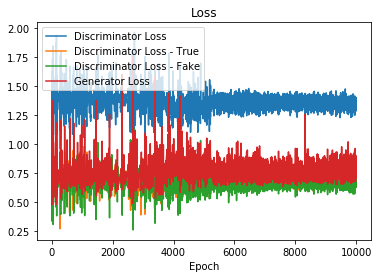

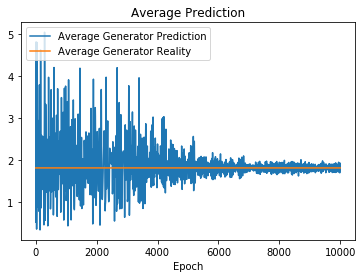

In [17]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## Checking output

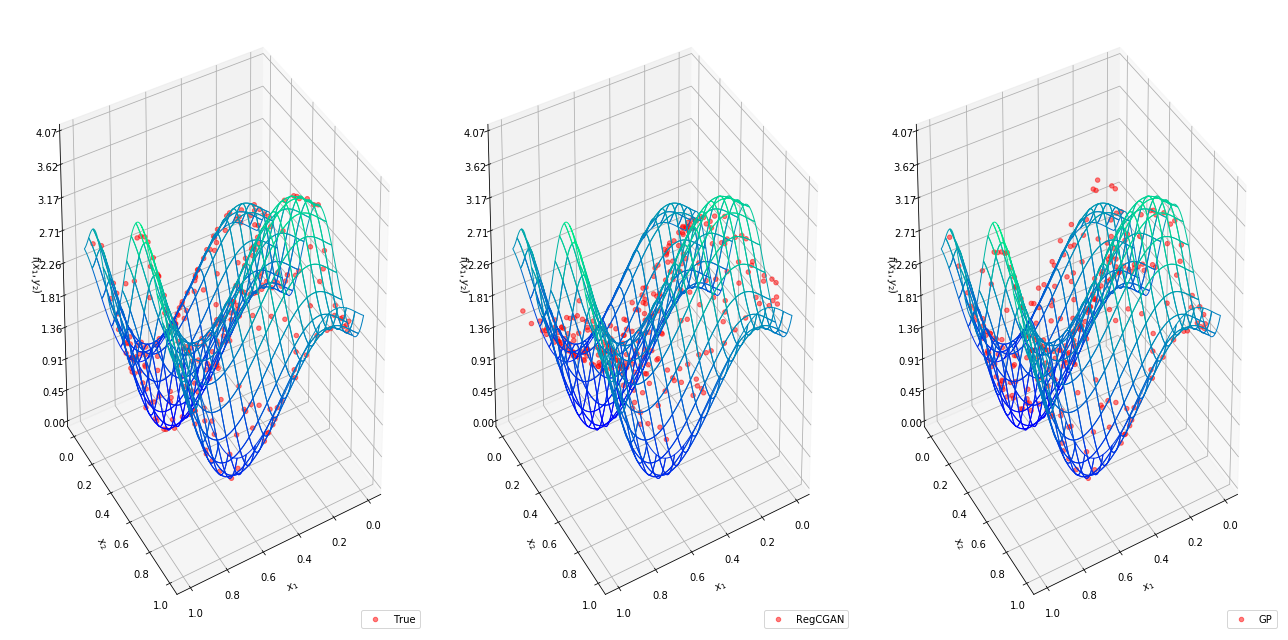

In [13]:
# Predictions using RegCGAN against GP
plotting.plot_ypred_with_locations(X_valid, y_valid, ypred_regcgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="RegCGAN_GP", save_fig=exp_config.run.save_fig,
                          alpha=0.5, elevation=30, azimuth=60)


In [ ]:
plotting.plot_ypred(y_valid, ypred_regcgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="RegCGAN_GP", save_fig=exp_config.run.save_fig)

## Marginalized density of P(y) 

In [ ]:
plotting.plot_densities_joint(y_valid, ypred_regcgan_valid, ypred_gp_valid,
                              title=r"Marginalized $P(y)$", fig_dir=fig_dir,
                              prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

## Conditional probability P(y|x)

In [ ]:
num_sampling = 200 # increase sample_size to have gaussian densities for GP
_, _, X, y = dataset.get_dataset(exp_config.dataset.n_instance, exp_config.dataset.scenario)

ypred_regcgan_sam = regcgan._make_sampling(X)

ypred_gp, cov = gpr.predict(X)
ypred_gp_sam = np.random.normal(ypred_gp, np.sqrt(cov))
for i in range(1, exp_config.training.n_sampling):
    ypred_gp_sam = np.hstack([ypred_gp_sam, np.random.normal(ypred_gp, np.sqrt(cov))])

In [ ]:
bins =[[0.91, 0.36], [0.29, 0.47], [0.63, 0.53]]
for (x1, x2) in bins:
    y_true = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (exp_config.training.n_sampling, 1)),
                                        y=np.tile(y, (exp_config.training.n_sampling, 1)))
    
    ypred_regccgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (exp_config.training.n_sampling, 1)),
                                        y=np.ravel(ypred_regcgan_sam.T).reshape(-1, 1))
    

    ypred_gp_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (exp_config.training.n_sampling, 1)),
                                        y=np.ravel(ypred_gp_sam.T).reshape(-1, 1))

    (y_true, ypred_regcgan_cond, ypred_gp_cond) = (y_true.reshape(-1, 1),
                                                      ypred_regcgan_cond.reshape(-1, 1),
                                                      ypred_gp_cond.reshape(-1, 1))

    plotting.plot_densities_joint(y_true.reshape(-1,1), 
                                  ypred_regccgan_cond.reshape(-1, 1),
                                  ypred_gp_cond.reshape(-1, 1),
                                  title = f"conditional density of $P(y|x_1={x1},x_2={x2})$ ", fig_dir=fig_dir, 
                                  prefix=f"condition_density_P(y|x1={x1},x2={x2})", save_fig=exp_config.run.save_fig)


## Metrics on validation samples

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

single_cgan_mae_list = []
single_cgan_mse_list= []

mean_cgan_mae_list = []
mean_cgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 50
for i in range(n_eval_runs):
    ypred_single_cgan = cgan.predict(X_valid)
    single_cgan_mae_list.append(mean_absolute_error(y_valid, ypred_single_cgan))
    single_cgan_mse_list.append(mean_squared_error(y_valid, ypred_single_cgan))

    ypred_mean_cgan, _, _ = cgan.sample(X_valid, exp_config.training.n_samples)
    mean_cgan_mae_list.append(mean_absolute_error(y_valid, ypred_mean_cgan))
    mean_cgan_mse_list.append(mean_squared_error(y_valid, ypred_mean_cgan))

    yped_gp = np.random.normal(ypred_gp_valid, np.sqrt(cov_valid))
    gp_mae_list.append(mean_absolute_error(y_valid, yped_gp))
    gp_mse_list.append(mean_squared_error(y_valid, yped_gp))


In [ ]:
single_cgan_mae_mean, single_cgan_mae_std = np.mean(np.asarray(single_cgan_mae_list)), np.std(np.asarray(single_cgan_mae_list))
single_cgan_mse_mean, single_cgan_mse_std = np.mean(np.asarray(single_cgan_mse_list)), np.std(np.asarray(single_cgan_mse_list))

print(f"Single CGAN validation MAE: {single_cgan_mae_mean:.3f} +- {single_cgan_mae_std:.5f}")
print(f"Single CGAN validation MSE: {single_cgan_mse_mean:.3f} +- {single_cgan_mse_std:.5f}")

mean_cgan_mae_mean, mean_cgan_mae_std = np.mean(np.asarray(mean_cgan_mae_list)), np.std(np.asarray(mean_cgan_mae_list))
mean_cgan_mse_mean, mean_cgan_mse_std = np.mean(np.asarray(mean_cgan_mse_list)), np.std(np.asarray(mean_cgan_mse_list))

print(f"Mean CGAN validation MAE: {mean_cgan_mae_mean:.3f} +- {mean_cgan_mae_std:.5f}")
print(f"Mean CGAN validation MSE: {mean_cgan_mse_mean:.3f} +- {mean_cgan_mse_std:.5f}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"GP validation MAE: {gp_mae_mean:.3f} +- {gp_mae_std:.5f}")
print(f"GP validation MSE: {gp_mse_mean:.3f} +- {gp_mse_std:.5f}")

In [ ]:
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, np.random.normal(ypred_gp_valid, np.sqrt(cov_valid)), cov_valid))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"GP validation NLPD: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

In [ ]:

nlpd_list = []
for i in range(n_eval_runs):
    ypred_single_cgan_valid = cgan.predict(X_valid)
    cov = np.ones(len(ypred_single_cgan_valid))* np.mean((y_valid - ypred_single_cgan_valid)**2)
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, ypred_single_cgan_valid, cov))
single_cgan_nlpd_mean = np.mean(nlpd_list)
single_cgan_nlpd_std = np.std(nlpd_list)
print(f"Single CGAN Validation NLPD: {single_cgan_nlpd_mean:.3f} +- {single_cgan_nlpd_std:.5f}")

In [ ]:
_, w, _ = metrics.Parzen(cgan, X_train, y_train)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(cgan, X_valid, y_valid, w, exp_config.training.n_samples))
mean_cgan_nlpd_mean = np.mean(nlpd_list)
mean_cgan_nlpd_std = np.std(nlpd_list)
print(f"Mean CGAN Validation NLPD: {mean_cgan_nlpd_mean:.3f} +- {mean_cgan_nlpd_std:.5f}")

In [ ]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_validation.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"===Validation MAE===\n")
    file.write(f"GP validation MAE: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"Single CGAN validation MAE: {single_cgan_mae_mean} +- {single_cgan_mae_std}\n")
    file.write(f"Mean CGAN validation MAE: {mean_cgan_mae_mean} +- {mean_cgan_mae_std}\n")
    file.write(f"===Validation MSE===\n")
    file.write(f"GP validation MSE: {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"Single CGAN validation MSE: {single_cgan_mse_mean} +- {single_cgan_mse_std}\n")
    file.write(f"CGAN validation MSE: {mean_cgan_mse_mean} +- {mean_cgan_mse_std}\n")
    file.write(f"===Validation NLPD===\n")
    file.write(f"GP Gaussian NLPD: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"Single CGAN NLPD: {single_cgan_nlpd_mean} +- {single_cgan_nlpd_std}\n")
    file.write(f"Mean CGAN NLPD: {mean_cgan_nlpd_mean} +- {mean_cgan_nlpd_std}\n")
    file.close()